# PROJE BAŞLIĞI: EEG Sinyallerinden Duygu Tanıma
#### VERİ KÜMESİ: DREAMER (Dreaming via Electroencephalogram & Electrocardiogram)
#### YÖNTEM: CNN-LSTM Hibrit Mimarisi + Diferansiyel Entropi (DE) Öznitelikleri

# 1. GİRİŞ VE PROJE ÖZETİ

## 1.1 EEG Tabanlı Duygu Tanıma ve Önemi

Duygu tanıma, insan-bilgisayar etkileşiminde kritik bir rol oynamaktadır.
Geleneksel yöntemler (yüz ifadesi, ses tonu analizi) öznel ve manipüle edilebilir
olduğundan, nörofizyolojik sinyaller üzerinden duygu tanıma önem kazanmıştır.

Elektroensefalografi (EEG), beyin aktivitesini yüksek zamansal çözünürlükle
ölçen invazif olmayan bir yöntemdir. EEG sinyalleri:
- Bilinçli kontrolün dışındadır (objektif ölçüm)
- Milisaniye düzeyinde zamansal çözünürlük sağlar
- Düşük maliyetlidir ve portatif cihazlarla kullanılabilir

## 1.2 DREAMER Veri Kümesi

DREAMER veri kümesi, duygusal video uyaranlarına karşı kaydedilen EEG ve EKG
sinyallerini içerir:
- **23 denek**: Sağlıklı yetişkin bireyler
- **14 kanal EEG**: Uluslararası 10-20 sistemi (AF3, AF4, F3, F4, F7, F8, FC5,
  FC6, T7, T8, P7, P8, O1, O2)
- **18 film klibi**: Her biri yaklaşık 4 dakika uzunluğunda
- **Örnekleme frekansı**: 128 Hz
- **Duygu etiketleri**: Valence (değerlik), Arousal (uyarılmışlık) ve
  Dominance (baskınlık) için 1-5 arası öz-bildirim skorları

Bu çalışmada, yaygın olarak kullanılan iki boyuta odaklanılmıştır:
1. **Valence (Değerlik)**: Olumlu-olumsuz duygu ekseni
2. **Arousal (Uyarılmışlık)**: Sakin-heyecanlı duygu ekseni

## 1.3 Önerilen Yaklaşımın Yenilikçi Yönü

Mevcut literatürde EEG tabanlı duygu tanıma çalışmaları genellikle:
- Sadece CNN mimarileri (uzamsal özellikler)
- Sadece RNN/LSTM mimarileri (zamansal özellikler)
- Ham EEG verisi veya basit istatistiksel özellikler kullanır

**Bu çalışmanın yenilikçi katkıları:**

1. **Hibrit CNN-LSTM Mimarisi**:
   - CNN katmanları: Kanal-frekans bant matrisi üzerindeki yerel uzamsal
     örüntüleri (topoğrafik bilgi) öğrenir
   - LSTM katmanları: Farklı frekans bantları ve kanallar arasındaki
     karmaşık bağımlılıkları ve ardışık ilişkileri modeller

2. **Diferansiyel Entropi (DE) Öznitelikleri**:
   - Ham EEG verisi yerine, her frekans bandı için DE hesaplanır
   - DE, sinyal gücünün logaritmik ölçüsüdür ve duygusal durumlarla yüksek
     korelasyon gösterir (Duan et al., 2013; Zheng & Lu, 2015)
   - 5 frekans bandı (δ, θ, α, β, γ) × 14 kanal = 70 boyutlu kompakt öznitelik

3. **Denek-Bağımsız Değerlendirme (LOSO Cross-Validation)**:
   - Gerçek dünya senaryolarını simüle eder
   - Modelin genelleme yeteneğini daha güvenilir şekilde ölçer
   - Akademik çalışmalarda altın standart olarak kabul edilir

**Hipotez**: Hibrit mimari, hem lokal uzamsal örüntüleri hem de global
zamansal bağımlılıkları yakalayarak, tek başına CNN veya RNN yaklaşımlarından
daha yüksek sınıflandırma başarısı sağlayacaktır.

# 2. KÜTÜPHANE İÇE AKTARIMLARI

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.signal import butter, filtfilt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# TensorFlow ve Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical

# Sklearn
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score



In [ ]:
# Versiyonları kontrol et
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"NumPy Version: {np.__version__}")

TensorFlow Version: 2.19.0
Keras Version: 3.10.0
NumPy Version: 2.0.2


In [ ]:
# Rastgelelik kontrolü (tekrarlanabilirlik için)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## 3.1 DREAMER Veri Kümesinin Yapısı

DREAMER veri kümesi MATLAB (.mat) formatında saklanır. Yapısı:
- 'DREAMER.mat' dosyası içinde 'DREAMER' adlı yapı dizisi
- Her denek için bir yapı elemanı
- Her yapı: 'Data' (EEG/EKG), 'ScoreValence', 'ScoreArousal', vb. içerir

**Veri Organizasyonu**:
- Data.EEG: (18 deneme × 14 kanal × zaman adımı) boyutlu matris
- ScoreValence/Arousal: (18 deneme × 1) boyutlu etiket vektörü
- Skorlar 1-5 arası (1=çok düşük, 5=çok yüksek)

## 3.2 Veri Yükleme Fonksiyonu

In [ ]:
import numpy as np
from scipy.io import loadmat
from pprint import pprint

mat = loadmat('/content/drive/MyDrive/dreamer/DREAMER.mat',
              struct_as_record=False, squeeze_me=True)
d = mat.get('DREAMER')

print("TYPE of DREAMER:", type(d))
print("\nTop-level attributes / fields (filtered):")
attrs = [a for a in dir(d) if not a.startswith('_')]
# Print attribute names and types (first 200 attrs if many)
for name in attrs:
    try:
        val = getattr(d, name)
        print(f" - {name:20} : {type(val)}", end='')
        # Show brief shape/info for arrays
        if isinstance(val, np.ndarray):
            print(f", shape={val.shape}, dtype={val.dtype}")
        else:
            # For simple types print repr clipped
            rep = repr(val)
            print(f", repr={rep[:120] + ('...' if len(rep) > 120 else '')}")
    except Exception as e:
        print(f" - {name:20} : ERROR reading attribute ({e})")

# Now inspect Data field specifically (very likely present per PDF)
data = getattr(d, 'Data', None)
print("\nData attribute found?:", data is not None)
if data is not None:
    print("Data type:", type(data))
    # If ndarray/object array, print length and first element summary
    try:
        # make sure it's iterable
        subjects = np.atleast_1d(data)
        print("Number of subjects in Data (len):", len(subjects))
        first = subjects.flatten()[0]
        print("\nFirst subject type:", type(first))
        first_fields = [f for f in dir(first) if not f.startswith('_')]
        print("First subject field names (sample):", first_fields[:40])
        # Try to show ScoreValence and EEG existence
        print("Has ScoreValence?:", hasattr(first, 'ScoreValence'))
        print("Has ScoreArousal?:", hasattr(first, 'ScoreArousal'))
        print("Has EEG?:", hasattr(first, 'EEG'))
        if hasattr(first, 'ScoreValence'):
            sv = getattr(first, 'ScoreValence')
            print(" ScoreValence type/shape:", type(sv), getattr(sv, 'shape', None), "repr sample:", repr(sv)[:120])
    except Exception as e:
        print("Error while inspecting Data:", e)


TYPE of DREAMER: <class 'scipy.io.matlab._mio5_params.mat_struct'>

Top-level attributes / fields (filtered):
 - Acknowledgement      : <class 'str'>, repr='The authors would like to thank Thomas Cuntz and Sebastian Palke for the data collection under their BSc (Hons) project...
 - Data                 : <class 'numpy.ndarray'>, shape=(23,), dtype=object
 - Disclaimer           : <class 'str'>, repr='While every care has been taken to ensure the accuracy of the data included in the DREAMER dataset, the authors and the...
 - ECG_SamplingRate     : <class 'int'>, repr=256
 - EEG_Electrodes       : <class 'numpy.ndarray'>, shape=(14,), dtype=object
 - EEG_SamplingRate     : <class 'int'>, repr=128
 - Provider             : <class 'str'>, repr='University of the West of Scotland'
 - Version              : <class 'str'>, repr='1.0.2'
 - noOfSubjects         : <class 'int'>, repr=23
 - noOfVideoSequences   : <class 'int'>, repr=18

Data attribute found?: True
Data type: <class 'numpy.ndarray

In [ ]:
import numpy as np
from scipy.io import loadmat

def load_dreamer_from_matstruct(mat_path):
    """
    Load DREAMER when mat['DREAMER'] is a mat_struct with Data as subjects.
    Returns:
      eeg_trials : list of ndarray (samples x channels)  -- one item per stimulus trial
      valence_arr : np.ndarray (n_trials,)
      arousal_arr : np.ndarray (n_trials,)
      subject_ids  : np.ndarray (n_trials,) ints 0..n_subjects-1
    """
    mat = loadmat(mat_path, struct_as_record=False, squeeze_me=True)
    if 'DREAMER' not in mat:
        raise ValueError("DREAMER not found in .mat file")
    dreamer = mat['DREAMER']

    # Data should be an array (23 subjects)
    data = getattr(dreamer, 'Data', None)
    if data is None:
        raise ValueError("DREAMER.Data not found. Inspect the mat structure.")
    # ensure iterable list/array of subject structs
    subjects = np.atleast_1d(data).flatten()

    eeg_trials = []
    valence_list = []
    arousal_list = []
    subject_ids = []

    for subj_idx, subj in enumerate(subjects):
        # safe accessors
        score_v = getattr(subj, 'ScoreValence', None)
        score_a = getattr(subj, 'ScoreArousal', None)
        eeg_struct = getattr(subj, 'EEG', None)

        if score_v is None or score_a is None:
            raise ValueError(f"Subject {subj_idx} missing ScoreValence/ScoreArousal fields")

        # Convert scores to 1D numpy arrays
        score_v = np.asarray(score_v).flatten()
        score_a = np.asarray(score_a).flatten()

        if eeg_struct is None:
            raise ValueError(f"Subject {subj_idx} missing EEG field")

        # EEG may have .stimuli as array of 18 trials (or be the stimuli array itself)
        stimuli = getattr(eeg_struct, 'stimuli', None)
        if stimuli is None:
            # fallback to eeg_struct itself (sometimes the stimuli array is stored directly)
            stimuli = eeg_struct

        # normalize to iterable list of trials
        trials = np.atleast_1d(stimuli).flatten()

        for trial_idx, trial in enumerate(trials):
            if trial is None:
                continue
            trial_arr = np.asarray(trial)
            if trial_arr.size == 0:
                continue
            # trial_arr should be (M,14) per PDF. Keep as-is
            eeg_trials.append(trial_arr)
            # align label by trial_idx if available, else np.nan
            if trial_idx < len(score_v):
                valence_list.append(float(score_v[trial_idx]))
                arousal_list.append(float(score_a[trial_idx]))
            else:
                valence_list.append(np.nan)
                arousal_list.append(np.nan)
            subject_ids.append(subj_idx)

    valence_arr = np.array(valence_list)
    arousal_arr = np.array(arousal_list)
    subject_ids = np.array(subject_ids)

    print(f"Loaded {len(subjects)} subjects -> total trials: {len(eeg_trials)}")
    if len(eeg_trials):
        print("Example trial shape (samples x channels):", eeg_trials[0].shape)

    return eeg_trials, valence_arr, arousal_arr, subject_ids

## 3.3 Etiket Dönüştürme: Sürekli → İkili Sınıf

Duygu skorları 1-5 arası sürekli değerlerdir. İkili sınıflandırma için:
- Valence: ≥3 → Pozitif (1), <3 → Negatif (0)
- Arousal: ≥3 → Yüksek (1), <3 → Düşük (0)

**Gerekçe**:
- 3 değeri, 1-5 ölçeğinin orta noktasıdır
- Literatürde yaygın olarak kullanılır (Zhang et al., 2020)
- Dengeli sınıf dağılımı sağlar

In [ ]:
# ---------- Helper: normalize trials to (channels, samples) ----------
def normalize_trials(eeg_trials, expected_channels=14):
    """
    Ensure each trial array has shape (channels, samples).
    Input trials are typically (samples, 14) (as in DREAMER) -> transposed.
    Returns a list of ndarray shaped (channels, samples).
    """
    normalized = []
    for i, tr in enumerate(eeg_trials):
        arr = np.asarray(tr)
        if arr.size == 0:
            continue
        # if shape is (samples, channels) and channels == expected_channels, transpose:
        if arr.ndim == 2 and arr.shape[1] == expected_channels and arr.shape[0] != expected_channels:
            arr = arr.T  # -> (channels, samples)
        elif arr.ndim == 2 and arr.shape[0] == expected_channels:
            # Already channels x samples
            pass
        else:
            # Unexpected shape: try to guess or raise
            # If one dim equals expected_channels, bring it to first axis
            if arr.ndim == 2 and arr.shape[0] == expected_channels:
                pass
            elif arr.ndim == 2 and arr.shape[1] == expected_channels:
                arr = arr.T
            else:
                # last resort: reshape if product matches, but safer to skip
                raise ValueError(f"Trial {i} has unexpected shape {arr.shape}. Expected one axis == {expected_channels}.")
        normalized.append(arr)
    return normalized

# ---------- convert_to_binary_labels (works with 1D numpy of per-trial scores) ----------
def convert_to_binary_labels(scores, threshold=3.0):
    """
    Convert continuous per-trial scores (1D array) into binary labels using threshold.
    scores : ndarray shape (n_trials,)
    """
    scores = np.asarray(scores).flatten()
    binary_labels = (scores >= threshold).astype(int)

    # get counts safely
    unique, counts = np.unique(binary_labels, return_counts=True)
    count_dict = dict(zip(unique, counts))
    c0 = count_dict.get(0, 0)
    c1 = count_dict.get(1, 0)
    total = c0 + c1
    if total > 0:
        balance = (min(c0, c1) / max(c0, c1) * 100) if max(c0, c1) > 0 else 0.0
    else:
        balance = 0.0

    print(f"Sınıf dağılımı - 0: {c0}, 1: {c1}")
    print(f"Denge oranı: {balance:.1f}%")

    return binary_labels

# ---------- DE feature extraction adapted to (channels, samples) trials ----------
def extract_de_features(eeg_trial, fs=SAMPLING_FREQ):
    """
    Compute DE features for a single trial.
    eeg_trial: ndarray with shape (channels, samples)  -> (14, T)
    Returns flattened (14 * n_bands,) vector.
    """
    eeg_trial = np.asarray(eeg_trial)
    if eeg_trial.ndim != 2:
        raise ValueError(f"eeg_trial must be 2D (channels, samples). Got shape {eeg_trial.shape}")

    num_channels = eeg_trial.shape[0]
    num_bands = len(FREQ_BANDS)
    de_features = np.zeros((num_channels, num_bands))

    # iterate channels
    for ch_idx in range(num_channels):
        channel_signal = eeg_trial[ch_idx, :]

        for band_idx, (band_name, (low, high)) in enumerate(FREQ_BANDS.items()):
            # Apply bandpass - ensure length > order*3
            try:
                filtered_signal = butter_bandpass_filter(channel_signal, low, high, fs)
            except Exception as e:
                # fallback: if filter fails (too short), compute DE on raw channel
                filtered_signal = channel_signal
            de = compute_differential_entropy(filtered_signal)
            de_features[ch_idx, band_idx] = de

    return de_features.flatten()

# ---------- extract_all_de_features for flat list of trials ----------
def extract_all_de_features(eeg_trials):
    """
    Extract DE features from a flat list of trials. Each trial -> (channels, samples).
    Returns numpy array shape (n_trials, n_features) where n_features = 14 * n_bands.
    """
    print("DE öznitelikleri çıkarılıyor...")

    # normalize shapes (transposes where needed)
    normalized = normalize_trials(eeg_trials, expected_channels=14)

    all_features = []
    total = len(normalized)
    for idx, trial in enumerate(normalized):
        de_feat = extract_de_features(trial)
        all_features.append(de_feat)
        # progress print every 50 or last
        if (idx + 1) % 50 == 0 or (idx + 1) == total:
            print(f"  {idx + 1}/{total} trial işlendi")

    all_features = np.vstack(all_features)  # (n_trials, 70)
    print(f"✓ Öznitelik çıkarımı tamamlandı: {all_features.shape}")

    return all_features

In [ ]:
def convert_to_binary_labels(scores, threshold=3.0):
    """
    Sürekli duygu skorlarını ikili sınıflara dönüştürür.

    Parametreler:
    -----------
    scores : list of ndarray
        Denek başına duygu skorları
    threshold : float
        Eşik değeri (varsayılan: 3.0)

    Dönüş:
    ------
    binary_labels : ndarray
        İkili etiketler (0 veya 1)
    """
    all_scores = np.concatenate(scores)
    binary_labels = (all_scores >= threshold).astype(int)

    # Sınıf dağılımını kontrol et
    unique, counts = np.unique(binary_labels, return_counts=True)
    print(f"Sınıf dağılımı - 0: {counts[0]}, 1: {counts[1]}")
    print(f"Denge oranı: {min(counts)/max(counts)*100:.1f}%")

    return binary_labels

# 4. FREKANS BANDI FİLTRELEME

## 4.1 EEG Frekans Bantları ve Nörofizyolojik Anlam

EEG sinyali, farklı frekans bantlarında önemli bilgiler taşır:

| Bant | Frekans (Hz) | Nörofizyolojik İlişki |
|------|--------------|------------------------|
| δ (Delta) | 0.5-4 | Derin uyku, bilinçsizlik |
| θ (Theta) | 4-8 | Hafif uyku, meditasyon, duygusal işleme |
| α (Alpha) | 8-14 | Rahatlamış uyanıklık, gözler kapalı |
| β (Beta) | 14-30 | Aktif düşünme, konsantrasyon, anksiyete |
| γ (Gamma) | 30-47 | Bilişsel işleme, dikkat |

**Duygu Tanımadaki Rolü**:
- **α bandı**: Pozitif duygularla ilişkili (frontal asimetri)
- **β bandı**: Yüksek arousal ve stres göstergesi
- **θ bandı**: Duygusal hafıza ve işleme
- **γ bandı**: Duygusal uyaranların bilinçli algılanması

## 4.2 Butterworth Band-Pass Filtresi

Butterworth filtresi, frekans bandı ayırma için tercih edilir çünkü:
- Geçirme bandında düz frekans yanıtı sağlar (özellik çarpıtması minimum)
- Faz gecikmesi sıfıra yakındır (filtfilt ile çift yönlü uygulama)
- Numerik kararlılıktır

**Filtre Parametreleri**:
- Sıra (order): 4 (daha yüksek sıra → daha keskin geçiş, daha fazla hesaplama)
- Uygulama: filtfilt (sıfır faz gecikmesi için ileri-geri filtreleme)

In [ ]:
# Örnekleme frekansı (DREAMER veri kümesi için)
SAMPLING_FREQ = 128  # Hz

# Frekans bantları tanımı
FREQ_BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 47)
}

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Butterworth band-pass filtresi uygular.

    Parametreler:
    -----------
    data : ndarray
        Filtrelenecek sinyal
    lowcut : float
        Alt kesim frekansı (Hz)
    highcut : float
        Üst kesim frekansı (Hz)
    fs : float
        Örnekleme frekansı (Hz)
    order : int
        Filtre sırası

    Dönüş:
    ------
    filtered_data : ndarray
        Filtrelenmiş sinyal
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # Butterworth filtre katsayıları
    b, a = butter(order, [low, high], btype='band')

    # Sıfır faz gecikmeli filtreleme
    filtered_data = filtfilt(b, a, data, axis=-1)

    return filtered_data

# 5. DİFERANSİYEL ENTROPİ (DE) ÖZNİTELİK ÇIKARIMI

## 5.1 Diferansiyel Entropi (DE) Teorik Temeli

Diferansiyel Entropi, Gaussian dağılımlı bir rastgele değişkenin belirsizlik
ölçüsüdür. Bir X rastgele değişkeni için:

    DE(X) = (1/2) * log(2πeσ²)

Burada σ² varyans (güç) ifade eder. EEG sinyali yaklaşık olarak Gaussian
dağılımlı olduğunda:

    DE ≈ (1/2) * log(2πe) + (1/2) * log(var(X))
    DE ≈ (1/2) * log(var(X)) + constant

Sabit terim ihmal edildiğinde:

    DE ≈ log(var(X))

**DE'nin Avantajları**:
1. **Güç spektrumu ile ilişkili**: EEG gücünün logaritmik ölçüsü
2. **Duygusal durumlarla yüksek korelasyon**:
   - Pozitif duygular → α/β bantlarında yüksek DE
   - Negatif duygular → δ/θ bantlarında yüksek DE
3. **Boyut azaltma**: Ham EEG (14 kanal × binlerce örneklem) → Kompakt temsil
4. **Literatürde kanıtlanmış**: Zheng & Lu (2015) %86+ başarı göstermiştir

## 5.2 DE Hesaplama Algoritması

Her bir deneme için:
1. EEG sinyalini frekans bantlarına ayır (5 bant)
2. Her bant için her kanalda varyansı hesapla
3. DE = log(var + ε) (ε: sayısal kararlılık için küçük sabit)
4. Sonuç: (14 kanal × 5 bant) = 70 boyutlu öznitelik vektörü

In [ ]:
def compute_differential_entropy(signal):
    """
    Bir sinyal için diferansiyel entropi hesaplar.

    Parametreler:
    -----------
    signal : ndarray
        EEG sinyal kesiti

    Dönüş:
    ------
    de : float
        Diferansiyel entropi değeri
    """
    # Varyans hesapla
    variance = np.var(signal)

    # Sayısal kararlılık için epsilon ekle
    epsilon = 1e-10

    # DE = log(var)
    de = np.log(variance + epsilon)

    return de

def extract_de_features(eeg_trial, fs=SAMPLING_FREQ):
    """
    Bir deneme için tüm kanallardan DE özniteliklerini çıkarır.

    Parametreler:
    -----------
    eeg_trial : ndarray
        Tek bir deneme verisi (14 kanal × T örneklem)
    fs : float
        Örnekleme frekansı

    Dönüş:
    ------
    de_features : ndarray
        DE öznitelikleri (14 kanal × 5 bant = 70 öznitelik)
    """
    num_channels = eeg_trial.shape[0]
    num_bands = len(FREQ_BANDS)

    de_features = np.zeros((num_channels, num_bands))

    for ch_idx in range(num_channels):
        channel_signal = eeg_trial[ch_idx, :]

        for band_idx, (band_name, (low, high)) in enumerate(FREQ_BANDS.items()):
            # Frekans bandı filtreleme
            filtered_signal = butter_bandpass_filter(
                channel_signal, low, high, fs
            )

            # DE hesapla
            de = compute_differential_entropy(filtered_signal)
            de_features[ch_idx, band_idx] = de

    # (14, 5) matrisini (70,) vektöre düzleştir
    de_features_flat = de_features.flatten()

    return de_features_flat

## 5.3 Tüm Veri Kümesi için DE Öznitelik Çıkarımı

Bu işlem hesaplama açısından yoğundur:
- 23 denek × 18 deneme = 414 deneme
- Her deneme: 14 kanal × 5 bant filtreleme
- Tahmini süre: Birkaç dakika

In [ ]:
def extract_all_de_features(eeg_data):
    """
    Tüm denek ve denemeler için DE özniteliklerini çıkarır.

    Parametreler:
    -----------
    eeg_data : list of ndarray
        Her denek için EEG verisi

    Dönüş:
    ------
    all_features : ndarray
        Tüm öznitelikler (toplam_deneme × 70)
    """
    all_features = []

    print("DE öznitelikleri çıkarılıyor...")

    for subject_idx, subject_eeg in enumerate(eeg_data):
        num_trials = subject_eeg.shape[0]

        for trial_idx in range(num_trials):
            trial_data = subject_eeg[trial_idx]  # (14 kanal, T örneklem)

            # DE öznitelik çıkarımı
            de_features = extract_de_features(trial_data)
            all_features.append(de_features)

        if (subject_idx + 1) % 5 == 0:
            print(f"  {subject_idx + 1}/{len(eeg_data)} denek işlendi")

    all_features = np.array(all_features)
    print(f"✓ Öznitelik çıkarımı tamamlandı: {all_features.shape}")

    return all_features

# 6. VERİ SETİ HAZIRLIĞI VE NORMALLEŞTIRME

## 6.1 Leave-One-Subject-Out (LOSO) Çapraz Doğrulama

**LOSO Yaklaşımının Önemi**:

Geleneksel rastgele bölme (train/test split), aynı denekten farklı denemeleri
hem eğitim hem de test setine yerleştirebilir. Bu, yapay olarak yüksek başarı
ölçümlerine yol açar çünkü:
- Her bireyin benzersiz EEG özellikleri vardır
- Model, belirli bir bireye "overfitting" yapabilir

**LOSO Çözümü**:
- Her iterasyonda, bir denek tamamen test setine ayrılır
- Kalan 22 denek eğitim için kullanılır
- 23 iterasyon sonunda, her deneğin test sonucu elde edilir
- Gerçek dünya senaryosunu simüle eder (yeni bir kullanıcı için tahmin)

**Akademik Gerekçe**:
- "Subject-independent" değerlendirme literatürde altın standarttır
- Daha düşük başarı oranları, daha güvenilir sonuçlardır
- İyi modeller %65-80 arası başarı gösterir (subject-dependent %85-95)

## 6.2 Veri Normalleştirme (Standardization)

**Z-score Normalleştirme**:
    x_normalized = (x - μ) / σ

**Neden Gerekli**:
- Farklı frekans bantlarının güç seviyeleri farklıdır (örn: α >> γ)
- Gradyan iniş optimizasyonu için ölçek tutarlılığı gerekir
- Modelin yakınsama hızını artırır

**LOSO'da Önemli Nokta**:
- Her fold için StandardScaler, sadece eğitim verisi üzerinde fit edilir
- Test verisi, eğitim verisinin μ ve σ değerleri ile normalize edilir
- Bu, veri sızıntısını (data leakage) önler

In [ ]:
def prepare_loso_folds(features, labels, subject_ids):
    """
    LOSO çapraz doğrulama için veri katlarını hazırlar.

    Parametreler:
    -----------
    features : ndarray
        Öznitelik matrisi (N × 70)
    labels : ndarray
        Etiket vektörü (N,)
    subject_ids : ndarray
        Denek kimlikleri (N,)

    Dönüş:
    ------
    folds : list of tuples
        Her fold için (X_train, X_test, y_train, y_test) tuple'ları
    """
    logo = LeaveOneGroupOut()
    folds = []

    print(f"LOSO: {len(np.unique(subject_ids))} fold oluşturuluyor...")

    for train_idx, test_idx in logo.split(features, labels, subject_ids):
        X_train, X_test = features[train_idx], features[test_idx]
        y_train, y_test = labels[train_idx], labels[test_idx]

        # Normalleştirme (sadece eğitim verisi üzerinde fit)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        folds.append((X_train, X_test, y_train, y_test))

    print(f"✓ {len(folds)} fold hazırlandı")

    return folds

# 7. HİBRİT CNN-LSTM MODEL MİMARİSİ

## 7.1 Mimari Tasarım Felsefesi

**Neden Hibrit Mimari?**

1. **CNN Katmanları**:
   - Amaç: 14 kanal × 5 bant matrisindeki yerel uzamsal örüntüleri yakalamak
   - Topoğrafik bilgi: Komşu elektrotlar ve frekans bantları arasındaki ilişki
   - Örnek: Frontal bölgede α bandı simetrisi (duygu lateralizasyonu)

2. **LSTM Katmanları**:
   - Amaç: Farklı kanallar ve bantlar arasındaki global bağımlılıkları öğrenmek
   - 70 boyutlu vektördeki ardışık ilişkileri modellemek
   - Uzun vadeli bağımlılıkları yakalamak

## 7.2 Önerilen Mimari Detayları

**Katman Yapısı**:
1. Giriş: (70,) → Reshape → (14, 5, 1) [Kanal, Bant, Kanal-sayısı]
2. Conv2D Blokları: Yerel örüntü tespiti
   - İlk Conv: 64 filtre (3×3) → BatchNorm → ReLU → MaxPool
   - İkinci Conv: 128 filtre (3×3) → BatchNorm → ReLU → MaxPool
3. Flatten → Reshape: CNN çıktısını LSTM için hazırla
4. LSTM Katmanı: 64 unit, return_sequences=False
5. Dropout: Overfitting önleme (0.5)
6. Dense Çıkış: 2 sınıf (softmax)

**Hiperparametre Gerekçeleri**:
- **Filtre sayıları (64, 128)**: Yeteri kadar kapasite, aşırı karmaşıklık yok
- **Kernel boyutu (3×3)**: 5×5'e göre daha az parametre, 2×2'ye göre daha fazla bağlam
- **LSTM unit sayısı (64)**: Dengeli öğrenme kapasitesi
- **Dropout (0.5)**: Standart regularizasyon değeri

In [ ]:
def build_hybrid_cnn_lstm_model(input_shape=(70,), num_classes=2):
    """
    Hibrit CNN-LSTM modeli oluşturur.

    Parametreler:
    -----------
    input_shape : tuple
        Giriş şekli (70,)
    num_classes : int
        Sınıf sayısı (2 - ikili sınıflandırma)

    Dönüş:
    ------
    model : keras.Model
        Derlenmemiş Keras modeli
    """

    inputs = keras.Input(shape=input_shape, name='input_features')

    # 70 boyutlu vektörü (14, 5, 1) matrise dönüştür
    # 14 kanal, 5 frekans bandı, 1 öznitelik kanalı
    x = layers.Reshape((14, 5, 1), name='reshape_to_2d')(inputs)

    # ==================== CNN BLOKLARI ====================

    # CNN Blok 1
    x = layers.Conv2D(64, kernel_size=(3, 3), padding='same', name='conv2d_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.Activation('relu', name='relu_1')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_1')(x)
    x = layers.Dropout(0.3, name='dropout_1')(x)

    # CNN Blok 2
    x = layers.Conv2D(128, kernel_size=(3, 3), padding='same', name='conv2d_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.Activation('relu', name='relu_2')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_2')(x)
    x = layers.Dropout(0.3, name='dropout_2')(x)

    # CNN çıktısını düzleştir
    x = layers.Flatten(name='flatten')(x)

    # ==================== LSTM BLOKLARI ====================

    # LSTM için yeniden şekillendir: (batch, timesteps, features)
    # Flatten çıktısını zaman adımlarına böl
    x = layers.Reshape((-1, 128), name='reshape_for_lstm')(x)

    # LSTM Katmanı
    x = layers.LSTM(64, return_sequences=False, name='lstm_1')(x)
    x = layers.Dropout(0.5, name='dropout_lstm')(x)

    # ==================== ÇIKIŞ KATMANI ====================

    # Tam bağlı katman
    x = layers.Dense(32, activation='relu', name='dense_1')(x)
    x = layers.Dropout(0.4, name='dropout_dense')(x)

    # Çıkış katmanı
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)

    # Model oluştur
    model = keras.Model(inputs=inputs, outputs=outputs, name='Hybrid_CNN_LSTM')

    return model

## 7.3 Model Derleme ve Optimizasyon Parametreleri

**Kayıp Fonksiyonu**: Sparse Categorical Crossentropy
- İkili sınıflandırma için uygun
- Etiketler one-hot encoded değil, integer formatında (0, 1)

**Optimizasyon**: Adam
- Adaptif öğrenme oranı
- Momentum ve RMSprop'un avantajlarını birleştirir
- Başlangıç öğrenme oranı: 0.001 (standart)

**Metrikler**:
- Accuracy: Genel başarı
- Precision: Pozitif tahminlerin doğruluğu
- Recall: Gerçek pozitiflerin yakalanma oranı
- F1-Score: Precision ve Recall'ın harmonik ortalaması (dengesiz veri için kritik)

In [ ]:

def compile_model(model, learning_rate=0.001):
    """
    Compile model without Keras Precision/Recall (compute them with sklearn after predictions).
    """
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']  # keep a safe accuracy metric
    )

    return model

In [ ]:
def compile_model(model, learning_rate=0.001):
    """
    Modeli derler.

    Parametreler:
    -----------
    model : keras.Model
        Derlenmemiş model
    learning_rate : float
        Öğrenme oranı

    Dönüş:
    ------
    model : keras.Model
        Derlenmiş model
    """

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )

    return model

# 8. MODEL EĞİTİMİ VE LOSO ÇAPRAZ DOĞRULAMA

## 8.1 Callback Fonksiyonları

**EarlyStopping**:
- Amaç: Overfitting'i önlemek
- İzlenen metrik: Doğrulama kaybı (val_loss)
- Sabır (patience): 15 epoch (iyileşme yoksa durdur)
- Mod: 'min' (kayıp minimize edilmeli)

**ModelCheckpoint**:
- Amaç: En iyi modeli kaydetmek
- Kriter: En düşük doğrulama kaybı
- save_best_only: True (sadece iyileşme olduğunda kaydet)

**ReduceLROnPlateau**:
- Amaç: Öğrenme oranını dinamik azaltmak
- Plato tespit edildiğinde (5 epoch iyileşme yok) → LR × 0.5
- Minimum LR: 1e-6

Bu callback'ler, modelin optimal yakınsamasını ve genelleme yeteneğini artırır.

In [ ]:
def create_callbacks(fold_idx, emotion_type):
    """
    Eğitim callback'lerini oluşturur.

    Parametreler:
    -----------
    fold_idx : int
        Fold numarası
    emotion_type : str
        'valence' veya 'arousal'

    Dönüş:
    ------
    callbacks_list : list
        Callback nesneleri listesi
    """

    # Early stopping
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    # Model checkpoint
    checkpoint_path = f'best_model_{emotion_type}_fold{fold_idx}.h5'
    model_checkpoint = callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )

    # Learning rate reduction
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    return [early_stop, model_checkpoint, reduce_lr]

## 8.2 LOSO Çapraz Doğrulama Eğitim Döngüsü

Her fold için:
1. Yeni bir model oluştur (transfer learning yok, her fold bağımsız)
2. Eğitim setinin %15'ini doğrulama için ayır
3. Model eğit (maksimum 100 epoch, early stopping ile)
4. Test setinde değerlendir
5. Tahminleri ve metrikleri sakla

Toplam 23 fold sonunda:
- Ortalama ve standart sapma hesapla
- Tüm tahminleri birleştirerek global metrikler hesapla

In [ ]:
def train_loso_cross_validation(folds, emotion_type, epochs=100, batch_size=32):
    """
    LOSO cross-validation training. Computes precision/recall/f1 with sklearn after each fold.
    """
    print(f"\n{'='*70}")
    print(f"  {emotion_type.upper()} İÇİN LOSO ÇAPRAZ DOĞRULAMA EĞİTİMİ")
    print(f"{'='*70}\n")

    fold_accuracies = []
    fold_f1_scores = []
    fold_precisions = []
    fold_recalls = []
    all_predictions = []
    all_true_labels = []
    histories = []

    for fold_idx, (X_train, X_test, y_train, y_test) in enumerate(folds):
        print(f"\n--- Fold {fold_idx + 1}/{len(folds)} ---")
        print(f"Eğitim boyutu: {X_train.shape[0]}, Test boyutu: {X_test.shape[0]}")

        # Yeni model oluştur
        model = build_hybrid_cnn_lstm_model()
        model = compile_model(model)

        # Callbacks
        fold_callbacks = create_callbacks(fold_idx, emotion_type)

        # Model eğitimi
        history = model.fit(
            X_train, y_train,
            validation_split=0.15,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=fold_callbacks,
            verbose=1  # set to 1 to see training progress per fold
        )

        # Test tahminleri (probabilities -> class indices)
        y_pred_proba = model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Convert to numpy arrays (ensure shapes)
        y_test_arr = np.asarray(y_test).flatten()
        y_pred_arr = np.asarray(y_pred).flatten()

        # Metrikler (sklearn)
        accuracy = accuracy_score(y_test_arr, y_pred_arr)
        f1 = f1_score(y_test_arr, y_pred_arr, average='weighted', zero_division=0)
        precision = precision_score(y_test_arr, y_pred_arr, average='weighted', zero_division=0)
        recall = recall_score(y_test_arr, y_pred_arr, average='weighted', zero_division=0)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_precisions.append(precision)
        fold_recalls.append(recall)

        all_predictions.extend(y_pred_arr.tolist())
        all_true_labels.extend(y_test_arr.tolist())
        histories.append(history)

        print(f"  Test Accuracy: {accuracy*100:.2f}%")
        print(f"  Test Precision (weighted): {precision*100:.2f}%")
        print(f"  Test Recall (weighted): {recall*100:.2f}%")
        print(f"  Test F1-Score (weighted): {f1*100:.2f}%")

    # Toplam sonuçlar
    print(f"\n{'='*70}")
    print(f"  {emotion_type.upper()} SONUÇLARI")
    print(f"{'='*70}")
    print(f"Ortalama Accuracy: {np.mean(fold_accuracies)*100:.2f}% ± {np.std(fold_accuracies)*100:.2f}%")
    print(f"Ortalama Precision: {np.mean(fold_precisions)*100:.2f}% ± {np.std(fold_precisions)*100:.2f}%")
    print(f"Ortalama Recall: {np.mean(fold_recalls)*100:.2f}% ± {np.std(fold_recalls)*100:.2f}%")
    print(f"Ortalama F1-Score: {np.mean(fold_f1_scores)*100:.2f}% ± {np.std(fold_f1_scores)*100:.2f}%")

    results = {
        'fold_accuracies': fold_accuracies,
        'fold_f1_scores': fold_f1_scores,
        'fold_precisions': fold_precisions,
        'fold_recalls': fold_recalls,
        'all_predictions': np.array(all_predictions),
        'all_true_labels': np.array(all_true_labels),
        'histories': histories,
        'mean_accuracy': np.mean(fold_accuracies),
        'std_accuracy': np.std(fold_accuracies),
        'mean_f1': np.mean(fold_f1_scores),
        'std_f1': np.std(fold_f1_scores),
        'mean_precision': np.mean(fold_precisions),
        'std_precision': np.std(fold_precisions),
        'mean_recall': np.mean(fold_recalls),
        'std_recall': np.std(fold_recalls)
    }

    return results

In [ ]:
def train_loso_cross_validation(folds, emotion_type, epochs=100, batch_size=32):
    """
    LOSO çapraz doğrulama ile model eğitir.

    Parametreler:
    -----------
    folds : list of tuples
        LOSO fold verileri
    emotion_type : str
        'valence' veya 'arousal'
    epochs : int
        Maksimum epoch sayısı
    batch_size : int
        Batch boyutu

    Dönüş:
    ------
    results : dict
        Eğitim sonuçları ve tahminler
    """

    print(f"\n{'='*70}")
    print(f"  {emotion_type.upper()} İÇİN LOSO ÇAPRAZ DOĞRULAMA EĞİTİMİ")
    print(f"{'='*70}\n")

    fold_accuracies = []
    fold_f1_scores = []
    all_predictions = []
    all_true_labels = []
    histories = []

    for fold_idx, (X_train, X_test, y_train, y_test) in enumerate(folds):
        print(f"\n--- Fold {fold_idx + 1}/{len(folds)} ---")
        print(f"Eğitim boyutu: {X_train.shape[0]}, Test boyutu: {X_test.shape[0]}")

        # Yeni model oluştur
        model = build_hybrid_cnn_lstm_model()
        model = compile_model(model)

        # Callbacks
        fold_callbacks = create_callbacks(fold_idx, emotion_type)

        # Model eğitimi
        history = model.fit(
            X_train, y_train,
            validation_split=0.15,  # Eğitim setinin %15'i doğrulama
            epochs=epochs,
            batch_size=batch_size,
            callbacks=fold_callbacks,
            verbose=0  # Çıktı karmaşasını azalt
        )

        # Test tahminleri
        y_pred_proba = model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Metrikler
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        all_predictions.extend(y_pred)
        all_true_labels.extend(y_test)
        histories.append(history)

        print(f"  Test Accuracy: {accuracy*100:.2f}%")
        print(f"  Test F1-Score: {f1*100:.2f}%")

    # Toplam sonuçlar
    print(f"\n{'='*70}")
    print(f"  {emotion_type.upper()} SONUÇLARI")
    print(f"{'='*70}")
    print(f"Ortalama Accuracy: {np.mean(fold_accuracies)*100:.2f}% ± {np.std(fold_accuracies)*100:.2f}%")
    print(f"Ortalama F1-Score: {np.mean(fold_f1_scores)*100:.2f}% ± {np.std(fold_f1_scores)*100:.2f}%")

    results = {
        'fold_accuracies': fold_accuracies,
        'fold_f1_scores': fold_f1_scores,
        'all_predictions': np.array(all_predictions),
        'all_true_labels': np.array(all_true_labels),
        'histories': histories,
        'mean_accuracy': np.mean(fold_accuracies),
        'std_accuracy': np.std(fold_accuracies),
        'mean_f1': np.mean(fold_f1_scores),
        'std_f1': np.std(fold_f1_scores)
    }

    return results

## 9.1 Eğitim Geçmişi Görselleştirme

Eğitim ve doğrulama kayıp/başarı grafikleri:
- Overfitting tespiti (eğitim-doğrulama ayrışması)
- Yakınsama analizi
- Early stopping etkisi

In [ ]:
def plot_training_history(histories, emotion_type):
    """
    Tüm fold'ların eğitim geçmişini görselleştirir.

    Parametreler:
    -----------
    histories : list
        Keras History nesneleri
    emotion_type : str
        'valence' veya 'arousal'
    """

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'{emotion_type.upper()} - Eğitim Geçmişi (Ortalama)',
                 fontsize=14, fontweight='bold')

    # Ortalama eğitim metrikleri hesapla
    avg_train_loss = np.mean([h.history['loss'] for h in histories], axis=0)
    avg_val_loss = np.mean([h.history['val_loss'] for h in histories], axis=0)
    avg_train_acc = np.mean([h.history['accuracy'] for h in histories], axis=0)
    avg_val_acc = np.mean([h.history['val_accuracy'] for h in histories], axis=0)

    epochs_range = range(1, len(avg_train_loss) + 1)

    # Kayıp grafiği
    axes[0].plot(epochs_range, avg_train_loss, 'b-', label='Eğitim Kaybı', linewidth=2)
    axes[0].plot(epochs_range, avg_val_loss, 'r-', label='Doğrulama Kaybı', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Kayıp', fontsize=12)
    axes[0].set_title('Model Kaybı', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Başarı grafiği
    axes[1].plot(epochs_range, avg_train_acc, 'b-', label='Eğitim Başarısı', linewidth=2)
    axes[1].plot(epochs_range, avg_val_acc, 'r-', label='Doğrulama Başarısı', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Başarı', fontsize=12)
    axes[1].set_title('Model Başarısı', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 9.2 Karmaşıklık Matrisi (Confusion Matrix)

Karmaşıklık matrisi, modelin hangi sınıfları karıştırdığını gösterir:
- Köşegen elemanlar: Doğru sınıflandırmalar
- Köşegen dışı: Hatalı sınıflandırmalar

**Yorumlama**:
- Yüksek recall, düşük precision → Çok fazla pozitif tahmin
- Düşük recall, yüksek precision → Çok muhafazakar tahmin

In [ ]:
def plot_confusion_matrix(y_true, y_pred, emotion_type):
    """
    Karmaşıklık matrisini görselleştirir.

    Parametreler:
    -----------
    y_true : ndarray
        Gerçek etiketler
    y_pred : ndarray
        Tahmin edilen etiketler
    emotion_type : str
        'valence' veya 'arousal'
    """

    cm = confusion_matrix(y_true, y_pred)

    # Sınıf isimleri
    if emotion_type == 'valence':
        class_names = ['Negatif', 'Pozitif']
    else:
        class_names = ['Düşük', 'Yüksek']

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Sayı'})
    plt.xlabel('Tahmin Edilen', fontsize=12)
    plt.ylabel('Gerçek', fontsize=12)
    plt.title(f'{emotion_type.upper()} - Karmaşıklık Matrisi',
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Normalize edilmiş versiyon
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Oran'})
    plt.xlabel('Tahmin Edilen', fontsize=12)
    plt.ylabel('Gerçek', fontsize=12)
    plt.title(f'{emotion_type.upper()} - Normalize Karmaşıklık Matrisi',
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 9.3 Detaylı Sınıflandırma Raporu

sklearn'ın classification_report fonksiyonu, her sınıf için:
- Precision: TP / (TP + FP)
- Recall: TP / (TP + FN)
- F1-Score: 2 × (Precision × Recall) / (Precision + Recall)
- Support: Her sınıftaki örnek sayısı

değerlerini hesaplar.

In [ ]:
def print_classification_report(y_true, y_pred, emotion_type):
    """
    Detaylı sınıflandırma raporunu yazdırır.

    Parametreler:
    -----------
    y_true : ndarray
        Gerçek etiketler
    y_pred : ndarray
        Tahmin edilen etiketler
    emotion_type : str
        'valence' veya 'arousal'
    """

    if emotion_type == 'valence':
        target_names = ['Negatif', 'Pozitif']
    else:
        target_names = ['Düşük', 'Yüksek']

    print(f"\n{'='*70}")
    print(f"  {emotion_type.upper()} - SINIFLANDIRMA RAPORU")
    print(f"{'='*70}\n")

    report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
    print(report)

# 10. ANA EĞİTİM PİPELINE

## 10.1 Veri Yükleme ve Ön İşleme Pipeline

UYARI: Bu notebook'un çalışması için DREAMER.mat dosyasının yolu
aşağıdaki değişkende belirtilmelidir.

Veri kümesi: https://zenodo.org/records/546113

# VERİ YOLU AYARI

In [ ]:
DATA_PATH = "/content/drive/MyDrive/dreamer/DREAMER.mat"  # DREAMER.mat dosyasının yolunu buraya yazın

In [ ]:
# Örnek kullanım için veri yolu kontrolü
import os

if not os.path.exists(DATA_PATH):
    print("="*70)
    print("  UYARI: DREAMER.mat dosyası bulunamadı!")
    print("="*70)
    print("\nLütfen aşağıdaki adımları takip edin:")
    print("1. DREAMER veri kümesini indirin:")
    print("   http://www.eecs.qmul.ac.uk/mmv/datasets/dreamer/")
    print("2. DREAMER.mat dosyasının yolunu DATA_PATH değişkenine atayın")
    print("3. Notebook'u yeniden çalıştırın")
    print("\nŞu anda demo amaçlı sentetik veri ile devam edilecek.")
    print("="*70)
    USE_DEMO_DATA = True
else:
    USE_DEMO_DATA = False
    print(f"✓ Veri dosyası bulundu: {DATA_PATH}")

✓ Veri dosyası bulundu: /content/drive/MyDrive/dreamer/DREAMER.mat


## 10.3 Ana Eğitim Fonksiyonu

In [ ]:
def main_pipeline():
    """
    Uçtan uca eğitim pipeline'ı.

    Parametreler:
    -----------
    use_demo : bool
        True ise sentetik veri kullan
    """

    print("\n" + "="*70)
    print("  DREAMER EEG DUYGU TANIMA PROJESİ")
    print("  Hibrit CNN-LSTM Mimarisi + DE Öznitelikleri")
    print("="*70 + "\n")

    # 1. Veri Yükleme
    eeg_trials, valence_arr, arousal_arr, subject_ids = load_dreamer_from_matstruct(DATA_PATH)

    # 2. İkili Etiket Dönüşümü
    print("\n--- İkili Etiket Dönüşümü ---")
    print("Valence:")
    valence_binary = convert_to_binary_labels(valence_arr, threshold=3.0)
    print("\nArousal:")
    arousal_binary = convert_to_binary_labels(arousal_arr, threshold=3.0)

    # 3. DE Öznitelik Çıkarımı
    print("\n--- DE Öznitelik Çıkarımı ---")
    features = extract_all_de_features(eeg_trials)

    print(f"\nÖznitelik matrisi şekli: {features.shape}")
    print(f"Valence etiket şekli: {valence_binary.shape}")
    print(f"Arousal etiket şekli: {arousal_binary.shape}")

    # 4. LOSO Fold Hazırlama - VALENCE
    print("\n--- VALENCE için LOSO Fold Hazırlama ---")
    valence_folds = prepare_loso_folds(features, valence_binary, subject_ids)

    # 5. LOSO Fold Hazırlama - AROUSAL
    print("\n--- AROUSAL için LOSO Fold Hazırlama ---")
    arousal_folds = prepare_loso_folds(features, arousal_binary, subject_ids)

    # 6. Model Eğitimi - VALENCE
    valence_results = train_loso_cross_validation(
        valence_folds,
        emotion_type='valence',
        epochs=100,  # Demo için azaltılabilir: epochs=20
        batch_size=32
    )

    # 7. Model Eğitimi - AROUSAL
    arousal_results = train_loso_cross_validation(
        arousal_folds,
        emotion_type='arousal',
        epochs=100,  # Demo için azaltılabilir: epochs=20
        batch_size=32
    )

    # 8. Sonuçların Görselleştirilmesi
    print("\n--- Sonuçlar Görselleştiriliyor ---")

    # Valence sonuçları
    plot_training_history(valence_results['histories'], 'valence')
    plot_confusion_matrix(
        valence_results['all_true_labels'],
        valence_results['all_predictions'],
        'valence'
    )
    print_classification_report(
        valence_results['all_true_labels'],
        valence_results['all_predictions'],
        'valence'
    )

    # Arousal sonuçları
    plot_training_history(arousal_results['histories'], 'arousal')
    plot_confusion_matrix(
        arousal_results['all_true_labels'],
        arousal_results['all_predictions'],
        'arousal'
    )
    print_classification_report(
        arousal_results['all_true_labels'],
        arousal_results['all_predictions'],
        'arousal'
    )

    # 9. Özet Tablo
    print("\n" + "="*70)
    print("  FİNAL SONUÇLAR ÖZETİ")
    print("="*70 + "\n")

    summary = pd.DataFrame({
        'Duygu Boyutu': ['Valence', 'Arousal'],
        'Ortalama Accuracy (%)': [
            f"{valence_results['mean_accuracy']*100:.2f} ± {valence_results['std_accuracy']*100:.2f}",
            f"{arousal_results['mean_accuracy']*100:.2f} ± {arousal_results['std_accuracy']*100:.2f}"
        ],
        'Ortalama F1-Score (%)': [
            f"{valence_results['mean_f1']*100:.2f} ± {valence_results['std_f1']*100:.2f}",
            f"{arousal_results['mean_f1']*100:.2f} ± {arousal_results['std_f1']*100:.2f}"
        ]
    })

    print(summary.to_string(index=False))
    print("\n" + "="*70)

    return valence_results, arousal_results

# 11. NOTEBOOK ÇALIŞTIRMA

## 11.1 Çalıştırma Talimatları

Bu notebook'u çalıştırmak için:

1. **Veri Hazırlığı**:
   - DREAMER.mat dosyasını indirin
   - DATA_PATH değişkenini güncelleyin

2. **Hesaplama Kaynakları**:
   - GPU önerilir (TPU opsiyonel)
   - RAM: En az 8GB
   - Tahmini süre: 2-4 saat (GPU), 8-12 saat (CPU)

3. **Hızlı Test İçin**:
   - epochs=20 olarak azaltın
   - batch_size=64 olarak artırın
   - Daha az fold ile test edin (ilk 5 denek)

## 11.2 Beklenen Sonuçlar

**Literatür Karşılaştırması**:
- DEAP veri kümesi (benzer): %75-85 (subject-independent)
- DREAMER veri kümesi:
  - Katsouris & Garoufallou (2021): %79.2 (Valence), %82.1 (Arousal)
  - Li et al. (2018): %83.6 (Valence), %85.2 (Arousal) - subject-dependent

**Bu Çalışmadan Beklenen**:
- Valence: %70-80 (subject-independent)
- Arousal: %72-82 (subject-independent)
- Hibrit mimari sayesinde, tek mimari yaklaşımlardan %3-5 daha iyi

## 11.3 Sonuçların Yorumlanması

**Yüksek Başarı Göstergeleri**:
- F1-Score > 0.75: İyi genelleme
- Düşük standart sapma (< 0.05): Tutarlı performans
- Balanced confusion matrix: Her iki sınıfı da iyi öğrenmiş

**Düşük Başarı Nedenleri**:
- Bireysel farklılıklar (LOSO'da beklenen)
- Veri dengesizliği
- Etiket kalitesi (öz-bildirim skorları subjektif)

**İyileştirme Önerileri**:
- Data augmentation (zaman ölçekleme, gürültü ekleme)
- Transfer learning (başka veri kümeleri ile ön-eğitim)
- Ensemble yöntemler (birden fazla modelin birleşimi)
- Attention mekanizmaları (önemli kanalları vurgulama)


  DREAMER EEG DUYGU TANIMA PROJESİ
  Hibrit CNN-LSTM Mimarisi + DE Öznitelikleri

Loaded 23 subjects -> total trials: 414
Example trial shape (samples x channels): (25472, 14)

--- İkili Etiket Dönüşümü ---
Valence:
Sınıf dağılımı - 0: 161, 1: 253
Denge oranı: 63.6%

Arousal:
Sınıf dağılımı - 0: 114, 1: 300
Denge oranı: 38.0%

--- DE Öznitelik Çıkarımı ---
DE öznitelikleri çıkarılıyor...
  50/414 trial işlendi
  100/414 trial işlendi
  150/414 trial işlendi
  200/414 trial işlendi
  250/414 trial işlendi
  300/414 trial işlendi
  350/414 trial işlendi
  400/414 trial işlendi
  414/414 trial işlendi
✓ Öznitelik çıkarımı tamamlandı: (414, 70)

Öznitelik matrisi şekli: (414, 70)
Valence etiket şekli: (414,)
Arousal etiket şekli: (414,)

--- VALENCE için LOSO Fold Hazırlama ---
LOSO: 23 fold oluşturuluyor...
✓ 23 fold hazırlandı

--- AROUSAL için LOSO Fold Hazırlama ---
LOSO: 23 fold oluşturuluyor...
✓ 23 fold hazırlandı

  VALENCE İÇİN LOSO ÇAPRAZ DOĞRULAMA EĞİTİMİ


--- Fold 1/23 ---
Eğ

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.7430 - sparse_categorical_accuracy: 0.4686 - val_loss: 0.6820 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6909 - sparse_categorical_accuracy: 0.5748 - val_loss: 0.6853 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6816 - sparse_categorical_accuracy: 0.6038 - val_loss: 0.6843 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6776 - sparse_categorical_accuracy: 0.5720

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6782 - sparse_categorical_accuracy: 0.5777 - val_loss: 0.6803 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6705 - sparse_categorical_accuracy: 0.6042

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6707 - sparse_categorical_accuracy: 0.6032 - val_loss: 0.6786 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6759 - sparse_categorical_accuracy: 0.6082

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6759 - sparse_categorical_accuracy: 0.6031 - val_loss: 0.6771 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6858 - sparse_categorical_accuracy: 0.5724

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6829 - sparse_categorical_accuracy: 0.5772 - val_loss: 0.6741 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6761 - sparse_categorical_accuracy: 0.5713

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6772 - sparse_categorical_accuracy: 0.5766 - val_loss: 0.6718 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6797 - sparse_categorical_accuracy: 0.5703 - val_loss: 0.6725 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6804 - sparse_categorical_accuracy: 0.5698 - val_loss: 0.6723 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6651 - sparse_categorical_accuracy: 0.6052 - val_loss: 0.6720 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6852 - sparse_categorical_accuracy: 0.5938

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6817 - sparse_categorical_accuracy: 0.5983 - val_loss: 0.6675 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6766 - sparse_categorical_accuracy: 0.5850 - val_loss: 0.6699 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6662 - sparse_categorical_accuracy: 0.5931 - val_loss: 0.6693 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 15/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6699 - sparse_categorical_accuracy: 0.6251

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6721 - sparse_categorical_accuracy: 0.6228 - val_loss: 0.6624 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 16/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6666 - sparse_categorical_accuracy: 0.6043 - val_loss: 0.6703 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 17/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6450 - sparse_categorical_accuracy: 0.5988 - val_loss: 0.6752 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 18/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6430 - sparse_categorical_accuracy: 0.6438 - val_loss: 0.6725 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 19/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6620 - sparse_categorical_accuracy: 0.6075 - val_loss: 0.6724 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 20/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.7163 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.6725 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6736 - sparse_categorical_accuracy: 0.6062 - val_loss: 0.6767 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6922 - sparse_categorical_accuracy: 0.5993 - val_loss: 0.6769 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6831 - sparse_categorical_accuracy: 0.5620 - val_loss: 0.6758 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6710 - sparse_categorical_accuracy: 0.5882

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6730 - sparse_categorical_accuracy: 0.5841 - val_loss: 0.6724 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6873 - sparse_categorical_accuracy: 0.6301

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6814 - sparse_categorical_accuracy: 0.6292 - val_loss: 0.6685 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6480 - sparse_categorical_accuracy: 0.6267 - val_loss: 0.6702 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6670 - sparse_categorical_accuracy: 0.6243 - val_loss: 0.6744 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6637 - sparse_categorical_accuracy: 0.6054 - val_loss: 0.6760 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6683 - sparse_categorical_accuracy: 0.6404 - val_loss: 0.6756 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6510 - sparse_categorical_accuracy: 0.6552 - val_loss: 0.6672 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 16/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6644 - sparse_categorical_accuracy: 0.6124 - val_loss: 0.6682 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 17/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6487 - sparse_categorical_accuracy: 0.6511 - val_loss: 0.6709 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 18/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6506 - sparse_categorical_accuracy: 0.6147 - val_loss: 0.6717 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 19/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6587 - sparse_categorical_accuracy: 0.6326 - val_loss: 0.6710 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 20/100
 9/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6362 - sparse_categorical_accuracy: 0.6188 - val_loss: 0.6657 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 25/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6466 - sparse_categorical_accuracy: 0.6508

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6466 - sparse_categorical_accuracy: 0.6471 - val_loss: 0.6645 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 26/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6544 - sparse_categorical_accuracy: 0.5959

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6532 - sparse_categorical_accuracy: 0.6002 - val_loss: 0.6641 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 27/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6279 - sparse_categorical_accuracy: 0.6345

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6299 - sparse_categorical_accuracy: 0.6336 - val_loss: 0.6628 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 28/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6603 - sparse_categorical_accuracy: 0.6341

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6567 - sparse_categorical_accuracy: 0.6298 - val_loss: 0.6625 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 29/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6426 - sparse_categorical_accuracy: 0.6383

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6423 - sparse_categorical_accuracy: 0.6374 - val_loss: 0.6611 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 30/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6574 - sparse_categorical_accuracy: 0.6468

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6580 - sparse_categorical_accuracy: 0.6449 - val_loss: 0.6602 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 31/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6222 - sparse_categorical_accuracy: 0.6777 - val_loss: 0.6615 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 32/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6376 - sparse_categorical_accuracy: 0.6397 - val_loss: 0.6604 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 33/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6261 - sparse_categorical_accuracy: 0.6155

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.6179 - val_loss: 0.6594 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 34/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6704 - sparse_categorical_accuracy: 0.6264

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.6655 - sparse_categorical_accuracy: 0.6310 - val_loss: 0.6589 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 35/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6514 - sparse_categorical_accuracy: 0.6046

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.6507 - sparse_categorical_accuracy: 0.6058 - val_loss: 0.6585 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 36/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6759 - sparse_categorical_accuracy: 0.6098

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.6708 - sparse_categorical_accuracy: 0.6134 - val_loss: 0.6557 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 37/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6357 - sparse_categorical_accuracy: 0.6192

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.6351 - sparse_categorical_accuracy: 0.6221 - val_loss: 0.6547 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 38/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.6452 - sparse_categorical_accuracy: 0.6736 - val_loss: 0.6551 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 39/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6377 - sparse_categorical_accuracy: 0.5986

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.6366 - sparse_categorical_accuracy: 0.6042 - val_loss: 0.6533 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 40/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6348 - sparse_categorical_accuracy: 0.6131

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.6369 - sparse_categorical_accuracy: 0.6126 - val_loss: 0.6510 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 41/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6602 - sparse_categorical_accuracy: 0.6187

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6614 - sparse_categorical_accuracy: 0.6180 - val_loss: 0.6501 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 42/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.6578 - val_loss: 0.6508 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 43/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6431 - sparse_categorical_accuracy: 0.6172

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.6431 - sparse_categorical_accuracy: 0.6150 - val_loss: 0.6483 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 44/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.6638

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6274 - sparse_categorical_accuracy: 0.6599 - val_loss: 0.6469 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 45/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6032 - sparse_categorical_accuracy: 0.6781

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6080 - sparse_categorical_accuracy: 0.6651 - val_loss: 0.6463 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 46/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6168 - sparse_categorical_accuracy: 0.6639 - val_loss: 0.6467 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 47/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6419 - sparse_categorical_accuracy: 0.6280 - val_loss: 0.6489 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 48/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6219 - sparse_categorical_accuracy: 0.6471 - val_loss: 0.6497 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 49/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6237 - sparse_categorical_accuracy: 0.6541 - val_loss: 0.6501 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 50/100
 9/11 ━━━━━━━━━━━━━━━━━━━


Epoch 55: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5988 - sparse_categorical_accuracy: 0.6703 - val_loss: 0.6462 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 56/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6650 - sparse_categorical_accuracy: 0.6275 - val_loss: 0.6465 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 57/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6179 - sparse_categorical_accuracy: 0.6999

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6190 - sparse_categorical_accuracy: 0.6935 - val_loss: 0.6456 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 58/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6272 - sparse_categorical_accuracy: 0.6594

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6283 - sparse_categorical_accuracy: 0.6561 - val_loss: 0.6446 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 59/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6336 - sparse_categorical_accuracy: 0.6305 - val_loss: 0.6446 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 60/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.6283 - val_loss: 0.6449 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 6.2500e-05
Epoch 61/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6274 - sparse_categorical_accuracy: 0.6638 - val_loss: 0.6448 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 6.2500e-05
Epoch 62/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6241 - sparse_categorical_accuracy: 0.6544

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6240 - sparse_categorical_accuracy: 0.6549 - val_loss: 0.6444 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 63/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6098 - sparse_categorical_accuracy: 0.6490

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6092 - sparse_categorical_accuracy: 0.6510 - val_loss: 0.6442 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 6.2500e-05
Epoch 64/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6478 - sparse_categorical_accuracy: 0.6845

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6419 - sparse_categorical_accuracy: 0.6814 - val_loss: 0.6440 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 6.2500e-05
Epoch 65/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6165 - sparse_categorical_accuracy: 0.6645 - val_loss: 0.6440 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 6.2500e-05
Epoch 66/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6456 - sparse_categorical_accuracy: 0.6063

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6471 - sparse_categorical_accuracy: 0.6147 - val_loss: 0.6439 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 6.2500e-05
Epoch 67/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6217 - sparse_categorical_accuracy: 0.6867 - val_loss: 0.6441 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 6.2500e-05
Epoch 68/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6290 - sparse_categorical_accuracy: 0.6604 - val_loss: 0.6446 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 6.2500e-05
Epoch 69/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5946 - sparse_categorical_accuracy: 0.6658
Epoch 69: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5999 - sparse_categorical_accuracy: 0.6574 - val_loss: 0.6445 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 6.2500e-05
Epoch 70/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.7076 - sparse_categorical_accuracy: 0.5551 - val_loss: 0.6790 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7277 - sparse_categorical_accuracy: 0.5127 - val_loss: 0.6839 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6829 - sparse_categorical_accuracy: 0.5849 - val_loss: 0.6835 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6818 - sparse_categorical_accuracy: 0.5835 - val_loss: 0.6862 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6923 - sparse_categorical_accuracy: 0.5733 - val_loss: 0.6834 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.7765 - sparse_categorical_accuracy: 0.4865 - val_loss: 0.6749 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6481 - sparse_categorical_accuracy: 0.6270

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.6554 - sparse_categorical_accuracy: 0.6199 - val_loss: 0.6695 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6971 - sparse_categorical_accuracy: 0.5943 - val_loss: 0.6751 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6801 - sparse_categorical_accuracy: 0.5912 - val_loss: 0.6735 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6758 - sparse_categorical_accuracy: 0.5762 - val_loss: 0.6713 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6861 - sparse_categorical_accuracy: 0.5683 - val_loss: 0.6698 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6647 - sparse_categorical_accuracy: 0.6189 - val_loss: 0.6685 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6660 - sparse_categorical_accuracy: 0.6217 - val_loss: 0.6699 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6720 - sparse_categorical_accuracy: 0.5719 - val_loss: 0.6711 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6507 - sparse_categorical_accuracy: 0.6179 - val_loss: 0.6704 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6657 - sparse_categorical_accuracy: 0.6104 - val_loss: 0.6725 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 14/100
 9/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6494 - sparse_categorical_accuracy: 0.6161 - val_loss: 0.6683 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 22/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6522 - sparse_categorical_accuracy: 0.5983

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6531 - sparse_categorical_accuracy: 0.5987 - val_loss: 0.6675 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 23/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6643 - sparse_categorical_accuracy: 0.5994

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6627 - sparse_categorical_accuracy: 0.6002 - val_loss: 0.6670 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 24/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6652 - sparse_categorical_accuracy: 0.6237

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6647 - sparse_categorical_accuracy: 0.6190 - val_loss: 0.6669 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 25/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6428 - sparse_categorical_accuracy: 0.6486

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6465 - sparse_categorical_accuracy: 0.6447 - val_loss: 0.6667 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 26/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6672 - sparse_categorical_accuracy: 0.6208

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6649 - sparse_categorical_accuracy: 0.6193 - val_loss: 0.6666 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 27/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6517 - sparse_categorical_accuracy: 0.6358

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6532 - sparse_categorical_accuracy: 0.6289 - val_loss: 0.6663 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 28/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6418 - sparse_categorical_accuracy: 0.6426

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6428 - sparse_categorical_accuracy: 0.6410 - val_loss: 0.6659 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 29/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6372 - sparse_categorical_accuracy: 0.6809

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6391 - sparse_categorical_accuracy: 0.6694 - val_loss: 0.6653 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 30/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6482 - sparse_categorical_accuracy: 0.6535

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6485 - sparse_categorical_accuracy: 0.6509 - val_loss: 0.6640 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 31/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6516 - sparse_categorical_accuracy: 0.6190

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6513 - sparse_categorical_accuracy: 0.6157 - val_loss: 0.6627 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 32/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6537 - sparse_categorical_accuracy: 0.6230

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6535 - sparse_categorical_accuracy: 0.6230 - val_loss: 0.6625 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 33/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6527 - sparse_categorical_accuracy: 0.6262

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6526 - sparse_categorical_accuracy: 0.6219 - val_loss: 0.6624 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 34/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6466 - sparse_categorical_accuracy: 0.6507 - val_loss: 0.6630 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 35/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6361 - sparse_categorical_accuracy: 0.6544 - val_loss: 0.6625 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 36/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6304 - sparse_categorical_accuracy: 0.6534

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6335 - sparse_categorical_accuracy: 0.6461 - val_loss: 0.6616 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 37/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6538 - sparse_categorical_accuracy: 0.6452

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6528 - sparse_categorical_accuracy: 0.6389 - val_loss: 0.6606 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 38/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6388 - sparse_categorical_accuracy: 0.6485

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6387 - sparse_categorical_accuracy: 0.6426 - val_loss: 0.6589 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 39/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6562 - sparse_categorical_accuracy: 0.6189

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.6553 - sparse_categorical_accuracy: 0.6197 - val_loss: 0.6578 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 40/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6566 - sparse_categorical_accuracy: 0.6217

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.6563 - sparse_categorical_accuracy: 0.6210 - val_loss: 0.6572 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 41/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6497 - sparse_categorical_accuracy: 0.6312

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6492 - sparse_categorical_accuracy: 0.6312 - val_loss: 0.6570 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 42/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6469 - sparse_categorical_accuracy: 0.5972

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6480 - sparse_categorical_accuracy: 0.5970 - val_loss: 0.6566 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 43/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6498 - sparse_categorical_accuracy: 0.6502

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6484 - sparse_categorical_accuracy: 0.6501 - val_loss: 0.6559 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 44/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6598 - sparse_categorical_accuracy: 0.6263

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6622 - sparse_categorical_accuracy: 0.6211 - val_loss: 0.6555 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 45/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6591 - sparse_categorical_accuracy: 0.6377

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6602 - sparse_categorical_accuracy: 0.6345 - val_loss: 0.6552 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 46/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6468 - sparse_categorical_accuracy: 0.5660

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6470 - sparse_categorical_accuracy: 0.5665 - val_loss: 0.6544 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 47/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6558 - sparse_categorical_accuracy: 0.5860

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6552 - sparse_categorical_accuracy: 0.5894 - val_loss: 0.6537 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 48/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6489 - sparse_categorical_accuracy: 0.6487

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6511 - sparse_categorical_accuracy: 0.6485 - val_loss: 0.6535 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 49/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6429 - sparse_categorical_accuracy: 0.6539 - val_loss: 0.6537 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 50/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6549 - sparse_categorical_accuracy: 0.5992 - val_loss: 0.6539 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 51/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6465 - sparse_categorical_accuracy: 0.6267 - val_loss: 0.6540 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 52/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6468 - sparse_categorical_accuracy: 0.6143 - val_loss: 0.6538 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 53/100
 9/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.7102 - sparse_categorical_accuracy: 0.5473 - val_loss: 0.6737 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.7166 - sparse_categorical_accuracy: 0.5542 - val_loss: 0.6814 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6651 - sparse_categorical_accuracy: 0.5765 - val_loss: 0.6835 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.6803 - sparse_categorical_accuracy: 0.5865 - val_loss: 0.6769 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6705 - sparse_categorical_accuracy: 0.6390

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.6719 - sparse_categorical_accuracy: 0.6298 - val_loss: 0.6695 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.6655 - sparse_categorical_accuracy: 0.6034 - val_loss: 0.6724 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.6530 - sparse_categorical_accuracy: 0.6108 - val_loss: 0.6724 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6562 - sparse_categorical_accuracy: 0.6111 - val_loss: 0.6708 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6360 - sparse_categorical_accuracy: 0.6708

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6413 - sparse_categorical_accuracy: 0.6609 - val_loss: 0.6665 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6943 - sparse_categorical_accuracy: 0.5889 - val_loss: 0.6697 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6649 - sparse_categorical_accuracy: 0.5965 - val_loss: 0.6701 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6822 - sparse_categorical_accuracy: 0.5680 - val_loss: 0.6734 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6766 - sparse_categorical_accuracy: 0.5802 - val_loss: 0.6743 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 14/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - los

  Test Accuracy: 61.11%
  Test Precision (weighted): 37.35%
  Test Recall (weighted): 61.11%
  Test F1-Score (weighted): 46.36%

--- Fold 6/23 ---
Eğitim boyutu: 396, Test boyutu: 18
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7524 - sparse_categorical_accuracy: 0.5279

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.7519 - sparse_categorical_accuracy: 0.5288 - val_loss: 0.6807 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7132 - sparse_categorical_accuracy: 0.5513

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7104 - sparse_categorical_accuracy: 0.5519 - val_loss: 0.6791 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6896 - sparse_categorical_accuracy: 0.5596

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6871 - sparse_categorical_accuracy: 0.5611 - val_loss: 0.6789 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6865 - sparse_categorical_accuracy: 0.5893 - val_loss: 0.6793 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6831 - sparse_categorical_accuracy: 0.5478

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6844 - sparse_categorical_accuracy: 0.5512 - val_loss: 0.6768 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6922 - sparse_categorical_accuracy: 0.5449

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6921 - sparse_categorical_accuracy: 0.5521 - val_loss: 0.6744 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6503 - sparse_categorical_accuracy: 0.6333

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6527 - sparse_categorical_accuracy: 0.6248 - val_loss: 0.6735 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6840 - sparse_categorical_accuracy: 0.5621

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6828 - sparse_categorical_accuracy: 0.5660 - val_loss: 0.6693 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6878 - sparse_categorical_accuracy: 0.5854

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.6872 - sparse_categorical_accuracy: 0.5853 - val_loss: 0.6653 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6821 - sparse_categorical_accuracy: 0.5677

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.6842 - sparse_categorical_accuracy: 0.5684 - val_loss: 0.6651 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6625 - sparse_categorical_accuracy: 0.6112

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.6648 - sparse_categorical_accuracy: 0.6056 - val_loss: 0.6650 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6709 - sparse_categorical_accuracy: 0.5576 - val_loss: 0.6657 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.6765 - sparse_categorical_accuracy: 0.5566 - val_loss: 0.6657 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6828 - sparse_categorical_accuracy: 0.5655 - val_loss: 0.6650 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 15/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.6660 - sparse_categorical_accuracy: 0.6422 - val_loss: 0.6661 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 16/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - los

  Test Accuracy: 66.67%
  Test Precision (weighted): 44.44%
  Test Recall (weighted): 66.67%
  Test F1-Score (weighted): 53.33%

--- Fold 7/23 ---
Eğitim boyutu: 396, Test boyutu: 18
Epoch 1/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7265 - sparse_categorical_accuracy: 0.5660

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.7242 - sparse_categorical_accuracy: 0.5694 - val_loss: 0.6741 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6816 - sparse_categorical_accuracy: 0.5975 - val_loss: 0.6827 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6594 - sparse_categorical_accuracy: 0.5829 - val_loss: 0.6791 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6741 - sparse_categorical_accuracy: 0.6028 - val_loss: 0.6767 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6639 - sparse_categorical_accuracy: 0.5706

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6675 - sparse_categorical_accuracy: 0.5638 - val_loss: 0.6724 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6705 - sparse_categorical_accuracy: 0.6037

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6749 - sparse_categorical_accuracy: 0.5982 - val_loss: 0.6708 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6393 - sparse_categorical_accuracy: 0.6335

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6443 - sparse_categorical_accuracy: 0.6277 - val_loss: 0.6668 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6614 - sparse_categorical_accuracy: 0.6224

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6682 - sparse_categorical_accuracy: 0.6186 - val_loss: 0.6657 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6565 - sparse_categorical_accuracy: 0.6089 - val_loss: 0.6667 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6565 - sparse_categorical_accuracy: 0.6239

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6577 - sparse_categorical_accuracy: 0.6187 - val_loss: 0.6654 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6853 - sparse_categorical_accuracy: 0.6026 - val_loss: 0.6655 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6481 - sparse_categorical_accuracy: 0.6263 - val_loss: 0.6669 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6497 - sparse_categorical_accuracy: 0.6480

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.6507 - sparse_categorical_accuracy: 0.6464 - val_loss: 0.6641 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6517 - sparse_categorical_accuracy: 0.6567 - val_loss: 0.6642 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 15/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6460 - sparse_categorical_accuracy: 0.6286

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6507 - sparse_categorical_accuracy: 0.6232 - val_loss: 0.6636 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 16/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.6623 - sparse_categorical_accuracy: 0.6302 - val_loss: 0.6654 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 17/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.6452 - sparse_categorical_accuracy: 0.6592 - val_loss: 0.6674 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 18/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6397 - sparse_categorical_accuracy: 0.6365

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6423 - sparse_categorical_accuracy: 0.6339 - val_loss: 0.6630 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 19/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6367 - sparse_categorical_accuracy: 0.6435 - val_loss: 0.6635 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 20/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6402 - sparse_categorical_accuracy: 0.6462 - val_loss: 0.6638 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 21/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6444 - sparse_categorical_accuracy: 0.6222

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6482 - sparse_categorical_accuracy: 0.6162 - val_loss: 0.6620 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 22/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6381 - sparse_categorical_accuracy: 0.6285

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6415 - sparse_categorical_accuracy: 0.6224 - val_loss: 0.6594 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 23/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6422 - sparse_categorical_accuracy: 0.6204

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6437 - sparse_categorical_accuracy: 0.6211 - val_loss: 0.6594 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 24/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6203 - sparse_categorical_accuracy: 0.6714 - val_loss: 0.6598 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 25/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6555 - sparse_categorical_accuracy: 0.6502 - val_loss: 0.6621 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 26/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6409 - sparse_categorical_accuracy: 0.6516

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6421 - sparse_categorical_accuracy: 0.6498 - val_loss: 0.6583 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 27/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6226 - sparse_categorical_accuracy: 0.6971

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.6821 - val_loss: 0.6543 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 28/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6524 - sparse_categorical_accuracy: 0.6429 - val_loss: 0.6551 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 29/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6250 - sparse_categorical_accuracy: 0.6383 - val_loss: 0.6570 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 30/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6234 - sparse_categorical_accuracy: 0.6939

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.6794 - val_loss: 0.6543 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 31/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6536 - sparse_categorical_accuracy: 0.6578

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6508 - sparse_categorical_accuracy: 0.6564 - val_loss: 0.6493 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 32/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6225 - sparse_categorical_accuracy: 0.6882

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6252 - sparse_categorical_accuracy: 0.6841 - val_loss: 0.6477 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 33/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6378 - sparse_categorical_accuracy: 0.6307 - val_loss: 0.6486 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 34/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6290 - sparse_categorical_accuracy: 0.6353 - val_loss: 0.6492 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 35/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6324 - sparse_categorical_accuracy: 0.6622 - val_loss: 0.6500 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 36/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6045 - sparse_categorical_accuracy: 0.7040 - val_loss: 0.6514 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 37/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5984 - sparse_categorical_accuracy: 0.6808 - val_loss: 0.6467 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 38/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6044 - sparse_categorical_accuracy: 0.7042

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6107 - sparse_categorical_accuracy: 0.6917 - val_loss: 0.6447 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 39/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5878 - sparse_categorical_accuracy: 0.6847 - val_loss: 0.6452 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 40/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6115 - sparse_categorical_accuracy: 0.7050 - val_loss: 0.6505 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 41/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5808 - sparse_categorical_accuracy: 0.6878 - val_loss: 0.6486 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 42/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6474 - sparse_categorical_accuracy: 0.6558 - val_loss: 0.6528 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 43/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5604 - sparse_categorical_accuracy: 0.7196 - val_loss: 0.6434 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 53/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5658 - sparse_categorical_accuracy: 0.7156

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5714 - sparse_categorical_accuracy: 0.7100 - val_loss: 0.6433 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 54/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5714 - sparse_categorical_accuracy: 0.7318 - val_loss: 0.6480 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 55/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.5429 - sparse_categorical_accuracy: 0.7654 - val_loss: 0.6552 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 56/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.5436 - sparse_categorical_accuracy: 0.7193 - val_loss: 0.6608 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 57/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.5600 - sparse_categorical_accuracy: 0.7172 - val_loss: 0.6530 - val_sparse_categorical_accuracy: 0.6667 - learning_rate: 2.5000e-04
Epoch 58/100
 9/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.7294 - sparse_categorical_accuracy: 0.5333 - val_loss: 0.6743 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7060 - sparse_categorical_accuracy: 0.5734 - val_loss: 0.6858 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6988 - sparse_categorical_accuracy: 0.5403 - val_loss: 0.6856 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6776 - sparse_categorical_accuracy: 0.5548 - val_loss: 0.6810 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6876 - sparse_categorical_accuracy: 0.5740 - val_loss: 0.6776 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.7508 - sparse_categorical_accuracy: 0.5019 - val_loss: 0.6732 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6755 - sparse_categorical_accuracy: 0.6166 - val_loss: 0.6739 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6938 - sparse_categorical_accuracy: 0.5565 - val_loss: 0.6735 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6613 - sparse_categorical_accuracy: 0.6095 - val_loss: 0.6745 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6835 - sparse_categorical_accuracy: 0.5941 - val_loss: 0.6794 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.7452 - sparse_categorical_accuracy: 0.5495 - val_loss: 0.6795 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7170 - sparse_categorical_accuracy: 0.5389 - val_loss: 0.6842 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6859 - sparse_categorical_accuracy: 0.5819 - val_loss: 0.6846 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6874 - sparse_categorical_accuracy: 0.5320 - val_loss: 0.6840 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6669 - sparse_categorical_accuracy: 0.5844 - val_loss: 0.6821 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6870 - sparse_categorical_accuracy: 0.5892 - val_loss: 0.6795 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 8/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6601 - sparse_categorical_accuracy: 0.6520

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.6634 - sparse_categorical_accuracy: 0.6435 - val_loss: 0.6776 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 9/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6791 - sparse_categorical_accuracy: 0.6240

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.6776 - sparse_categorical_accuracy: 0.6190 - val_loss: 0.6765 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 10/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6786 - sparse_categorical_accuracy: 0.6040

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.6823 - sparse_categorical_accuracy: 0.5941 - val_loss: 0.6760 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6776 - sparse_categorical_accuracy: 0.6055

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6775 - sparse_categorical_accuracy: 0.6036 - val_loss: 0.6747 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 12/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6640 - sparse_categorical_accuracy: 0.6175

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6669 - sparse_categorical_accuracy: 0.6068 - val_loss: 0.6743 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 13/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6626 - sparse_categorical_accuracy: 0.6128

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.6652 - sparse_categorical_accuracy: 0.6013 - val_loss: 0.6742 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 14/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6624 - sparse_categorical_accuracy: 0.6280

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6639 - sparse_categorical_accuracy: 0.6206 - val_loss: 0.6727 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 15/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6786 - sparse_categorical_accuracy: 0.6101

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6793 - sparse_categorical_accuracy: 0.6071 - val_loss: 0.6720 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 16/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6762 - sparse_categorical_accuracy: 0.5868

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6786 - sparse_categorical_accuracy: 0.5765 - val_loss: 0.6714 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 17/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6638 - sparse_categorical_accuracy: 0.6203

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6640 - sparse_categorical_accuracy: 0.6202 - val_loss: 0.6713 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 18/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6573 - sparse_categorical_accuracy: 0.6320

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6607 - sparse_categorical_accuracy: 0.6222 - val_loss: 0.6711 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 19/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6689 - sparse_categorical_accuracy: 0.6007

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6692 - sparse_categorical_accuracy: 0.5971 - val_loss: 0.6707 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 20/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6654 - sparse_categorical_accuracy: 0.6526 - val_loss: 0.6712 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 21/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6577 - sparse_categorical_accuracy: 0.5944 - val_loss: 0.6721 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 22/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6704 - sparse_categorical_accuracy: 0.6080 - val_loss: 0.6711 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 23/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6651 - sparse_categorical_accuracy: 0.6116

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6636 - sparse_categorical_accuracy: 0.6077 - val_loss: 0.6692 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 24/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6561 - sparse_categorical_accuracy: 0.6085

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6584 - sparse_categorical_accuracy: 0.6024 - val_loss: 0.6683 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 25/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6510 - sparse_categorical_accuracy: 0.6286

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6520 - sparse_categorical_accuracy: 0.6219 - val_loss: 0.6662 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 26/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6598 - sparse_categorical_accuracy: 0.6263

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6614 - sparse_categorical_accuracy: 0.6206 - val_loss: 0.6659 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 27/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6527 - sparse_categorical_accuracy: 0.6319 - val_loss: 0.6665 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 28/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6358 - sparse_categorical_accuracy: 0.6445

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6374 - sparse_categorical_accuracy: 0.6414 - val_loss: 0.6647 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 29/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6379 - sparse_categorical_accuracy: 0.6495

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6411 - sparse_categorical_accuracy: 0.6396 - val_loss: 0.6622 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 30/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6474 - sparse_categorical_accuracy: 0.6192 - val_loss: 0.6627 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 31/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6694 - sparse_categorical_accuracy: 0.6127

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6657 - sparse_categorical_accuracy: 0.6120 - val_loss: 0.6615 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 32/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6330 - sparse_categorical_accuracy: 0.6361

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6343 - sparse_categorical_accuracy: 0.6335 - val_loss: 0.6595 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 33/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6436 - sparse_categorical_accuracy: 0.6446

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6448 - sparse_categorical_accuracy: 0.6438 - val_loss: 0.6579 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 34/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6489 - sparse_categorical_accuracy: 0.6309

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6541 - sparse_categorical_accuracy: 0.6186 - val_loss: 0.6571 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 35/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6433 - sparse_categorical_accuracy: 0.6455 - val_loss: 0.6586 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 36/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6285 - sparse_categorical_accuracy: 0.6744 - val_loss: 0.6583 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 37/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6476 - sparse_categorical_accuracy: 0.6524 - val_loss: 0.6586 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 38/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6409 - sparse_categorical_accuracy: 0.6281 - val_loss: 0.6586 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 39/100
11/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6528 - sparse_categorical_accuracy: 0.6484 - val_loss: 0.6569 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 43/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6380 - sparse_categorical_accuracy: 0.6766

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6463 - sparse_categorical_accuracy: 0.6567 - val_loss: 0.6553 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 44/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6154 - sparse_categorical_accuracy: 0.6855

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6225 - sparse_categorical_accuracy: 0.6726 - val_loss: 0.6541 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 45/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6171 - sparse_categorical_accuracy: 0.6793

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6204 - sparse_categorical_accuracy: 0.6728 - val_loss: 0.6534 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 46/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.6555

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.6333 - sparse_categorical_accuracy: 0.6489 - val_loss: 0.6532 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 47/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6470 - sparse_categorical_accuracy: 0.6131

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.6473 - sparse_categorical_accuracy: 0.6146 - val_loss: 0.6524 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 48/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.6553 - sparse_categorical_accuracy: 0.6443 - val_loss: 0.6527 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 49/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.6286 - sparse_categorical_accuracy: 0.6868 - val_loss: 0.6524 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 50/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.6354 - sparse_categorical_accuracy: 0.6292 - val_loss: 0.6527 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 51/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6249 - sparse_categorical_accuracy: 0.6444 - val_loss: 0.6532 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 52/100
 9/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6383 - sparse_categorical_accuracy: 0.6511 - val_loss: 0.6522 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 56/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6510 - sparse_categorical_accuracy: 0.6390

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6497 - sparse_categorical_accuracy: 0.6388 - val_loss: 0.6520 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 57/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6310 - sparse_categorical_accuracy: 0.6605

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6304 - sparse_categorical_accuracy: 0.6585 - val_loss: 0.6517 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 58/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6302 - sparse_categorical_accuracy: 0.6816

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6297 - sparse_categorical_accuracy: 0.6732 - val_loss: 0.6511 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 59/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6323 - sparse_categorical_accuracy: 0.6437 - val_loss: 0.6512 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 60/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6637 - sparse_categorical_accuracy: 0.6372

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6638 - sparse_categorical_accuracy: 0.6355 - val_loss: 0.6506 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 61/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6236 - sparse_categorical_accuracy: 0.6627

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6239 - sparse_categorical_accuracy: 0.6623 - val_loss: 0.6503 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 62/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6240 - sparse_categorical_accuracy: 0.6413

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6269 - sparse_categorical_accuracy: 0.6406 - val_loss: 0.6499 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 1.2500e-04
Epoch 63/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6275 - sparse_categorical_accuracy: 0.6706

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.6660 - val_loss: 0.6494 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 1.2500e-04
Epoch 64/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6351 - sparse_categorical_accuracy: 0.6597

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6364 - sparse_categorical_accuracy: 0.6544 - val_loss: 0.6489 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 65/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6179 - sparse_categorical_accuracy: 0.6409

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.6182 - sparse_categorical_accuracy: 0.6416 - val_loss: 0.6485 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 66/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6248 - sparse_categorical_accuracy: 0.6924

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6294 - sparse_categorical_accuracy: 0.6851 - val_loss: 0.6480 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 67/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6252 - sparse_categorical_accuracy: 0.6802

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6245 - sparse_categorical_accuracy: 0.6775 - val_loss: 0.6479 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 68/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6127 - sparse_categorical_accuracy: 0.6922 - val_loss: 0.6486 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 1.2500e-04
Epoch 69/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5909 - sparse_categorical_accuracy: 0.7059 - val_loss: 0.6489 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 1.2500e-04
Epoch 70/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6344 - sparse_categorical_accuracy: 0.6471 - val_loss: 0.6490 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 1.2500e-04
Epoch 71/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6010 - sparse_categorical_accuracy: 0.6778
Epoch 71: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.6826 - sparse_categorical_accuracy: 0.6158 - val_loss: 0.6766 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6559 - sparse_categorical_accuracy: 0.6157 - val_loss: 0.6811 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6761 - sparse_categorical_accuracy: 0.6091 - val_loss: 0.6806 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6695 - sparse_categorical_accuracy: 0.5990 - val_loss: 0.6813 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6675 - sparse_categorical_accuracy: 0.5681 - val_loss: 0.6782 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6760 - sparse_categorical_accuracy: 0.6020 - val_loss: 0.6710 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6750 - sparse_categorical_accuracy: 0.5900

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6771 - sparse_categorical_accuracy: 0.5962 - val_loss: 0.6688 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6494 - sparse_categorical_accuracy: 0.6371 - val_loss: 0.6707 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6685 - sparse_categorical_accuracy: 0.6317 - val_loss: 0.6736 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6642 - sparse_categorical_accuracy: 0.6083 - val_loss: 0.6737 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6728 - sparse_categorical_accuracy: 0.6283 - val_loss: 0.6754 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss:

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.7435 - sparse_categorical_accuracy: 0.5079 - val_loss: 0.6790 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6664 - sparse_categorical_accuracy: 0.6097 - val_loss: 0.6804 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6847 - sparse_categorical_accuracy: 0.5543

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6849 - sparse_categorical_accuracy: 0.5535 - val_loss: 0.6773 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6566 - sparse_categorical_accuracy: 0.6074

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.6611 - sparse_categorical_accuracy: 0.6017 - val_loss: 0.6739 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6637 - sparse_categorical_accuracy: 0.6107

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6650 - sparse_categorical_accuracy: 0.6082 - val_loss: 0.6719 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6600 - sparse_categorical_accuracy: 0.6129 - val_loss: 0.6724 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6626 - sparse_categorical_accuracy: 0.6165 - val_loss: 0.6746 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6671 - sparse_categorical_accuracy: 0.6044 - val_loss: 0.6766 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6535 - sparse_categorical_accuracy: 0.6305 - val_loss: 0.6774 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.7130 - sparse_categorical_accuracy: 0.5334 - val_loss: 0.6710 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6727 - sparse_categorical_accuracy: 0.5909 - val_loss: 0.6743 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6899 - sparse_categorical_accuracy: 0.5790 - val_loss: 0.6806 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6772 - sparse_categorical_accuracy: 0.6192 - val_loss: 0.6803 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6838 - sparse_categorical_accuracy: 0.5551 - val_loss: 0.6807 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.7245 - sparse_categorical_accuracy: 0.5064 - val_loss: 0.6809 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.6767 - sparse_categorical_accuracy: 0.6141 - val_loss: 0.6815 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6649 - sparse_categorical_accuracy: 0.6252

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.6677 - sparse_categorical_accuracy: 0.6177 - val_loss: 0.6768 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6695 - sparse_categorical_accuracy: 0.6040

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6714 - sparse_categorical_accuracy: 0.6005 - val_loss: 0.6748 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6752 - sparse_categorical_accuracy: 0.6242 - val_loss: 0.6758 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6850 - sparse_categorical_accuracy: 0.5858

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6833 - sparse_categorical_accuracy: 0.5884 - val_loss: 0.6747 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6738 - sparse_categorical_accuracy: 0.6127

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6746 - sparse_categorical_accuracy: 0.6103 - val_loss: 0.6716 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6580 - sparse_categorical_accuracy: 0.6118

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.6591 - sparse_categorical_accuracy: 0.6017 - val_loss: 0.6708 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6515 - sparse_categorical_accuracy: 0.6384

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6539 - sparse_categorical_accuracy: 0.6357 - val_loss: 0.6672 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6560 - sparse_categorical_accuracy: 0.5989 - val_loss: 0.6679 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6588 - sparse_categorical_accuracy: 0.6290 - val_loss: 0.6727 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6379 - sparse_categorical_accuracy: 0.6450 - val_loss: 0.6726 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6645 - sparse_categorical_accuracy: 0.6367 - val_loss: 0.6757 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 14/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.7340 - sparse_categorical_accuracy: 0.5409 - val_loss: 0.6832 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6955 - sparse_categorical_accuracy: 0.5755 - val_loss: 0.6863 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6619 - sparse_categorical_accuracy: 0.6104

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6631 - sparse_categorical_accuracy: 0.6069 - val_loss: 0.6819 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6624 - sparse_categorical_accuracy: 0.6130

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6644 - sparse_categorical_accuracy: 0.6091 - val_loss: 0.6793 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6495 - sparse_categorical_accuracy: 0.6191

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6550 - sparse_categorical_accuracy: 0.6177 - val_loss: 0.6784 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6457 - sparse_categorical_accuracy: 0.6034

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6498 - sparse_categorical_accuracy: 0.6000 - val_loss: 0.6772 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6518 - sparse_categorical_accuracy: 0.6350 - val_loss: 0.6782 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6723 - sparse_categorical_accuracy: 0.6315

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6722 - sparse_categorical_accuracy: 0.6183 - val_loss: 0.6772 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6539 - sparse_categorical_accuracy: 0.6376 - val_loss: 0.6781 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6565 - sparse_categorical_accuracy: 0.6093 - val_loss: 0.6795 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6649 - sparse_categorical_accuracy: 0.6195
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6665 - sparse_categorical_accuracy: 0.6136 - val_loss: 0.6803 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6534 - sparse_cat

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.6719 - sparse_categorical_accuracy: 0.6488 - val_loss: 0.6798 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6432 - sparse_categorical_accuracy: 0.6534 - val_loss: 0.6809 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6809 - sparse_categorical_accuracy: 0.6016 - val_loss: 0.6837 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6746 - sparse_categorical_accuracy: 0.5896 - val_loss: 0.6888 - val_sparse_categorical_accuracy: 0.5000 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6561 - sparse_categorical_accuracy: 0.6223 - val_loss: 0.6842 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6564 - sparse_categorical_accuracy: 0.5948 - val_loss: 0.6764 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6627 - sparse_categorical_accuracy: 0.6335 - val_loss: 0.6764 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6585 - sparse_categorical_accuracy: 0.6227 - val_loss: 0.6787 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6556 - sparse_categorical_accuracy: 0.6155 - val_loss: 0.6770 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6413 - sparse_categorical_accuracy: 0.6541 - val_loss: 0.6770 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6301 - sparse_categorical_accuracy: 0.7039 - val_loss: 0.6756 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 19/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6394 - sparse_categorical_accuracy: 0.6026

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6428 - sparse_categorical_accuracy: 0.6031 - val_loss: 0.6748 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 20/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.6707

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6379 - sparse_categorical_accuracy: 0.6640 - val_loss: 0.6739 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 21/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6398 - sparse_categorical_accuracy: 0.6678

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6424 - sparse_categorical_accuracy: 0.6612 - val_loss: 0.6725 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 22/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6474 - sparse_categorical_accuracy: 0.6533 - val_loss: 0.6726 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 23/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6665 - sparse_categorical_accuracy: 0.6388 - val_loss: 0.6729 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 24/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6534 - sparse_categorical_accuracy: 0.6391

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6545 - sparse_categorical_accuracy: 0.6342 - val_loss: 0.6721 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 25/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6388 - sparse_categorical_accuracy: 0.6700

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6419 - sparse_categorical_accuracy: 0.6530 - val_loss: 0.6716 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 26/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6485 - sparse_categorical_accuracy: 0.6568

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6521 - sparse_categorical_accuracy: 0.6425 - val_loss: 0.6711 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 27/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6331 - sparse_categorical_accuracy: 0.6226

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6346 - sparse_categorical_accuracy: 0.6218 - val_loss: 0.6710 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 28/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6502 - sparse_categorical_accuracy: 0.6315

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.6501 - sparse_categorical_accuracy: 0.6302 - val_loss: 0.6705 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 29/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6074 - sparse_categorical_accuracy: 0.6720

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6149 - sparse_categorical_accuracy: 0.6623 - val_loss: 0.6687 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 30/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6451 - sparse_categorical_accuracy: 0.6540

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.6481 - sparse_categorical_accuracy: 0.6478 - val_loss: 0.6679 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 31/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6134 - sparse_categorical_accuracy: 0.6427

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6145 - sparse_categorical_accuracy: 0.6422 - val_loss: 0.6657 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 32/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6448 - sparse_categorical_accuracy: 0.6230

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6462 - sparse_categorical_accuracy: 0.6197 - val_loss: 0.6649 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 33/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6124 - sparse_categorical_accuracy: 0.6871

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6141 - sparse_categorical_accuracy: 0.6844 - val_loss: 0.6636 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 34/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.6477 - sparse_categorical_accuracy: 0.6307 - val_loss: 0.6638 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 35/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6226 - sparse_categorical_accuracy: 0.6558 - val_loss: 0.6650 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 36/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6191 - sparse_categorical_accuracy: 0.6478 - val_loss: 0.6642 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 37/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6319 - sparse_categorical_accuracy: 0.6817

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6362 - sparse_categorical_accuracy: 0.6748 - val_loss: 0.6618 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 38/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6329 - sparse_categorical_accuracy: 0.6460

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6347 - sparse_categorical_accuracy: 0.6392 - val_loss: 0.6606 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 39/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6117 - sparse_categorical_accuracy: 0.6380

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6140 - sparse_categorical_accuracy: 0.6359 - val_loss: 0.6600 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 2.5000e-04
Epoch 40/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5966 - sparse_categorical_accuracy: 0.6990

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6053 - sparse_categorical_accuracy: 0.6890 - val_loss: 0.6595 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 41/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6149 - sparse_categorical_accuracy: 0.6488

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6177 - sparse_categorical_accuracy: 0.6453 - val_loss: 0.6592 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 42/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6557 - sparse_categorical_accuracy: 0.6286

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6569 - sparse_categorical_accuracy: 0.6268 - val_loss: 0.6582 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 43/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6220 - sparse_categorical_accuracy: 0.6277 - val_loss: 0.6582 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 44/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6189 - sparse_categorical_accuracy: 0.6672 - val_loss: 0.6596 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 45/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6160 - sparse_categorical_accuracy: 0.6759 - val_loss: 0.6583 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 46/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6166 - sparse_categorical_accuracy: 0.6587 - val_loss: 0.6592 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 47/100
10/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6335 - sparse_categorical_accuracy: 0.6362 - val_loss: 0.6574 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 1.2500e-04
Epoch 51/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6218 - sparse_categorical_accuracy: 0.6674

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6247 - sparse_categorical_accuracy: 0.6608 - val_loss: 0.6564 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 1.2500e-04
Epoch 52/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6210 - sparse_categorical_accuracy: 0.6159

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6216 - sparse_categorical_accuracy: 0.6139 - val_loss: 0.6561 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 1.2500e-04
Epoch 53/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6448 - sparse_categorical_accuracy: 0.6274

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.6466 - sparse_categorical_accuracy: 0.6255 - val_loss: 0.6551 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 1.2500e-04
Epoch 54/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6128 - sparse_categorical_accuracy: 0.6942

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6142 - sparse_categorical_accuracy: 0.6867 - val_loss: 0.6545 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 1.2500e-04
Epoch 55/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6397 - sparse_categorical_accuracy: 0.6486

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6388 - sparse_categorical_accuracy: 0.6451 - val_loss: 0.6541 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 1.2500e-04
Epoch 56/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6165 - sparse_categorical_accuracy: 0.6977 - val_loss: 0.6542 - val_sparse_categorical_accuracy: 0.6667 - learning_rate: 1.2500e-04
Epoch 57/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6156 - sparse_categorical_accuracy: 0.6679 - val_loss: 0.6549 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 1.2500e-04
Epoch 58/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6184 - sparse_categorical_accuracy: 0.6498 - val_loss: 0.6558 - val_sparse_categorical_accuracy: 0.6667 - learning_rate: 1.2500e-04
Epoch 59/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6268 - sparse_categorical_accuracy: 0.6632 - val_loss: 0.6556 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 60/100
10/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.7460 - sparse_categorical_accuracy: 0.4940 - val_loss: 0.6760 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6468 - sparse_categorical_accuracy: 0.6462

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6511 - sparse_categorical_accuracy: 0.6407 - val_loss: 0.6751 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6503 - sparse_categorical_accuracy: 0.6009

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.6519 - sparse_categorical_accuracy: 0.6000 - val_loss: 0.6705 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7115 - sparse_categorical_accuracy: 0.5925 - val_loss: 0.6736 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6698 - sparse_categorical_accuracy: 0.6042 - val_loss: 0.6739 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6877 - sparse_categorical_accuracy: 0.5980 - val_loss: 0.6725 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6891 - sparse_categorical_accuracy: 0.6082 - val_loss: 0.6718 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.


Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6527 - sparse_categorical_accuracy: 0.6495 - val_loss: 0.6705 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.6586 - sparse_categorical_accuracy: 0.6161 - val_loss: 0.6705 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 15/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6660 - sparse_categorical_accuracy: 0.5991

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6662 - sparse_categorical_accuracy: 0.5980 - val_loss: 0.6704 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 16/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6506 - sparse_categorical_accuracy: 0.6485

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6521 - sparse_categorical_accuracy: 0.6402 - val_loss: 0.6701 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 17/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6602 - sparse_categorical_accuracy: 0.6180 - val_loss: 0.6703 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 18/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6440 - sparse_categorical_accuracy: 0.6529 - val_loss: 0.6704 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 19/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6620 - sparse_categorical_accuracy: 0.6551 - val_loss: 0.6703 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 20/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6457 - sparse_categorical_accuracy: 0.6386

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6478 - sparse_categorical_accuracy: 0.6353 - val_loss: 0.6700 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 21/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6408 - sparse_categorical_accuracy: 0.6456

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6433 - sparse_categorical_accuracy: 0.6407 - val_loss: 0.6697 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 22/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6394 - sparse_categorical_accuracy: 0.6690

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6419 - sparse_categorical_accuracy: 0.6641 - val_loss: 0.6691 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 23/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6383 - sparse_categorical_accuracy: 0.6346

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6409 - sparse_categorical_accuracy: 0.6325 - val_loss: 0.6686 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 24/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.6397 - sparse_categorical_accuracy: 0.6574

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.6409 - sparse_categorical_accuracy: 0.6552 - val_loss: 0.6682 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 25/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6525 - sparse_categorical_accuracy: 0.6406

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6532 - sparse_categorical_accuracy: 0.6383 - val_loss: 0.6679 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 26/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6157 - sparse_categorical_accuracy: 0.6795

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.6216 - sparse_categorical_accuracy: 0.6734 - val_loss: 0.6673 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 27/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6482 - sparse_categorical_accuracy: 0.6231

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.6526 - sparse_categorical_accuracy: 0.6160 - val_loss: 0.6665 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 28/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6445 - sparse_categorical_accuracy: 0.6417

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.6461 - sparse_categorical_accuracy: 0.6385 - val_loss: 0.6663 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 29/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6211 - sparse_categorical_accuracy: 0.6365

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.6273 - sparse_categorical_accuracy: 0.6286 - val_loss: 0.6662 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 30/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6455 - sparse_categorical_accuracy: 0.6168

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6473 - sparse_categorical_accuracy: 0.6136 - val_loss: 0.6653 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 31/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6392 - sparse_categorical_accuracy: 0.6267

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.6402 - sparse_categorical_accuracy: 0.6248 - val_loss: 0.6641 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 32/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.6521

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6301 - sparse_categorical_accuracy: 0.6481 - val_loss: 0.6618 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 33/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6652 - sparse_categorical_accuracy: 0.6443

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6645 - sparse_categorical_accuracy: 0.6440 - val_loss: 0.6605 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 34/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6239 - sparse_categorical_accuracy: 0.6087

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6301 - sparse_categorical_accuracy: 0.6098 - val_loss: 0.6587 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 35/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6140 - sparse_categorical_accuracy: 0.6807

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6168 - sparse_categorical_accuracy: 0.6734 - val_loss: 0.6578 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 36/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5977 - sparse_categorical_accuracy: 0.6971

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6027 - sparse_categorical_accuracy: 0.6901 - val_loss: 0.6563 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 37/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6365 - sparse_categorical_accuracy: 0.6181

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6374 - sparse_categorical_accuracy: 0.6206 - val_loss: 0.6548 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 38/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6522 - sparse_categorical_accuracy: 0.6153

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6511 - sparse_categorical_accuracy: 0.6169 - val_loss: 0.6545 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 39/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6005 - sparse_categorical_accuracy: 0.6583

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6055 - sparse_categorical_accuracy: 0.6547 - val_loss: 0.6534 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 40/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6168 - sparse_categorical_accuracy: 0.6674

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.6219 - sparse_categorical_accuracy: 0.6583 - val_loss: 0.6519 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 41/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6347 - sparse_categorical_accuracy: 0.6504

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6356 - sparse_categorical_accuracy: 0.6491 - val_loss: 0.6502 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 42/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6336 - sparse_categorical_accuracy: 0.6505 - val_loss: 0.6507 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 43/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6202 - sparse_categorical_accuracy: 0.6596

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6229 - sparse_categorical_accuracy: 0.6528 - val_loss: 0.6500 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 44/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6282 - sparse_categorical_accuracy: 0.6201

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6296 - sparse_categorical_accuracy: 0.6187 - val_loss: 0.6488 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 45/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6297 - sparse_categorical_accuracy: 0.6725 - val_loss: 0.6490 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 46/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6238 - sparse_categorical_accuracy: 0.6420 - val_loss: 0.6496 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 47/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6179 - sparse_categorical_accuracy: 0.6496 - val_loss: 0.6506 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 48/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6513 - sparse_categorical_accuracy: 0.6134 - val_loss: 0.6508 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 2.5000e-04
Epoch 49/100
 9/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6182 - sparse_categorical_accuracy: 0.6786 - val_loss: 0.6482 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 54/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6031 - sparse_categorical_accuracy: 0.6824

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6064 - sparse_categorical_accuracy: 0.6778 - val_loss: 0.6481 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 55/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5981 - sparse_categorical_accuracy: 0.6854 - val_loss: 0.6482 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 56/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6197 - sparse_categorical_accuracy: 0.6646 - val_loss: 0.6482 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 57/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6103 - sparse_categorical_accuracy: 0.6607 - val_loss: 0.6483 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 58/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6254 - sparse_categorical_accuracy: 0.6697 - val_loss: 0.6493 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 59/100
 8/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.6802 - sparse_categorical_accuracy: 0.5894 - val_loss: 0.6761 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6571 - sparse_categorical_accuracy: 0.6146

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6584 - sparse_categorical_accuracy: 0.6134 - val_loss: 0.6760 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6766 - sparse_categorical_accuracy: 0.6484 - val_loss: 0.6801 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6705 - sparse_categorical_accuracy: 0.5931 - val_loss: 0.6776 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6591 - sparse_categorical_accuracy: 0.5948

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6600 - sparse_categorical_accuracy: 0.5934 - val_loss: 0.6741 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6903 - sparse_categorical_accuracy: 0.6009 - val_loss: 0.6765 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6833 - sparse_categorical_accuracy: 0.5676 - val_loss: 0.6745 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 8/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6479 - sparse_categorical_accuracy: 0.6423

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6514 - sparse_categorical_accuracy: 0.6364 - val_loss: 0.6717 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 9/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6584 - sparse_categorical_accuracy: 0.6196

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.6592 - sparse_categorical_accuracy: 0.6165 - val_loss: 0.6710 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6792 - sparse_categorical_accuracy: 0.6187 - val_loss: 0.6720 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6596 - sparse_categorical_accuracy: 0.6345 - val_loss: 0.6724 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 12/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6451 - sparse_categorical_accuracy: 0.6382

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6486 - sparse_categorical_accuracy: 0.6335 - val_loss: 0.6701 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6487 - sparse_categorical_accuracy: 0.6381 - val_loss: 0.6705 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6549 - sparse_categorical_accuracy: 0.6390 - val_loss: 0.6710 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 15/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6522 - sparse_categorical_accuracy: 0.6454

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6539 - sparse_categorical_accuracy: 0.6415 - val_loss: 0.6662 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 16/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6587 - sparse_categorical_accuracy: 0.6462 - val_loss: 0.6670 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 17/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6549 - sparse_categorical_accuracy: 0.6204 - val_loss: 0.6686 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 18/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.6408 - sparse_categorical_accuracy: 0.6545 - val_loss: 0.6703 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 19/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6425 - sparse_categorical_accuracy: 0.6275 - val_loss: 0.6707 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 20/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.6198 - sparse_categorical_accuracy: 0.6255 - val_loss: 0.6640 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 26/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6337 - sparse_categorical_accuracy: 0.6512

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.6360 - sparse_categorical_accuracy: 0.6471 - val_loss: 0.6619 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 27/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.6141 - sparse_categorical_accuracy: 0.6446 - val_loss: 0.6633 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 5.0000e-04
Epoch 28/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5996 - sparse_categorical_accuracy: 0.6691

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6047 - sparse_categorical_accuracy: 0.6657 - val_loss: 0.6601 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 29/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6196 - sparse_categorical_accuracy: 0.6496

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6223 - sparse_categorical_accuracy: 0.6455 - val_loss: 0.6579 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 30/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6179 - sparse_categorical_accuracy: 0.6697

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6188 - sparse_categorical_accuracy: 0.6653 - val_loss: 0.6567 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 31/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6293 - sparse_categorical_accuracy: 0.6680 - val_loss: 0.6578 - val_sparse_categorical_accuracy: 0.6667 - learning_rate: 5.0000e-04
Epoch 32/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6232 - sparse_categorical_accuracy: 0.6313 - val_loss: 0.6588 - val_sparse_categorical_accuracy: 0.6667 - learning_rate: 5.0000e-04
Epoch 33/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5971 - sparse_categorical_accuracy: 0.6513 - val_loss: 0.6604 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 5.0000e-04
Epoch 34/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6340 - sparse_categorical_accuracy: 0.6720 - val_loss: 0.6583 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 35/100
11/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6056 - sparse_categorical_accuracy: 0.6885 - val_loss: 0.6561 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 36/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.6650 - val_loss: 0.6608 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 37/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6567 - sparse_categorical_accuracy: 0.6702 - val_loss: 0.6638 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 5.0000e-04
Epoch 38/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6032 - sparse_categorical_accuracy: 0.6890 - val_loss: 0.6617 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 5.0000e-04
Epoch 39/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5987 - sparse_categorical_accuracy: 0.6673

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6013 - sparse_categorical_accuracy: 0.6642 - val_loss: 0.6553 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 5.0000e-04
Epoch 40/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5910 - sparse_categorical_accuracy: 0.7063 - val_loss: 0.6568 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 41/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6105 - sparse_categorical_accuracy: 0.6835 - val_loss: 0.6595 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 5.0000e-04
Epoch 42/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6080 - sparse_categorical_accuracy: 0.6611 - val_loss: 0.6699 - val_sparse_categorical_accuracy: 0.5833 - learning_rate: 5.0000e-04
Epoch 43/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6121 - sparse_categorical_accuracy: 0.6578 - val_loss: 0.6691 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 44/100
10/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.7440 - sparse_categorical_accuracy: 0.5106 - val_loss: 0.6714 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.7056 - sparse_categorical_accuracy: 0.5616 - val_loss: 0.6723 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.7191 - sparse_categorical_accuracy: 0.5654 - val_loss: 0.6770 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6897 - sparse_categorical_accuracy: 0.5569 - val_loss: 0.6821 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6965 - sparse_categorical_accuracy: 0.5821 - val_loss: 0.6821 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.7177 - sparse_categorical_accuracy: 0.5658 - val_loss: 0.6797 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7148 - sparse_categorical_accuracy: 0.5445 - val_loss: 0.6865 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6843 - sparse_categorical_accuracy: 0.6067 - val_loss: 0.6826 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6839 - sparse_categorical_accuracy: 0.5606 - val_loss: 0.6811 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6723 - sparse_categorical_accuracy: 0.5803

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6741 - sparse_categorical_accuracy: 0.5793 - val_loss: 0.6790 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6869 - sparse_categorical_accuracy: 0.5914

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6873 - sparse_categorical_accuracy: 0.5901 - val_loss: 0.6774 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 7/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6842 - sparse_categorical_accuracy: 0.6088

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6847 - sparse_categorical_accuracy: 0.6035 - val_loss: 0.6772 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6608 - sparse_categorical_accuracy: 0.6377

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.6611 - sparse_categorical_accuracy: 0.6357 - val_loss: 0.6764 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6510 - sparse_categorical_accuracy: 0.6465

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6523 - sparse_categorical_accuracy: 0.6435 - val_loss: 0.6738 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.6549 - sparse_categorical_accuracy: 0.6281 - val_loss: 0.6744 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6574 - sparse_categorical_accuracy: 0.6079 - val_loss: 0.6756 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.6828 - sparse_categorical_accuracy: 0.6171 - val_loss: 0.6771 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.6522 - sparse_categorical_accuracy: 0.6293 - val_loss: 0.6778 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 14/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.6881 - sparse_categorical_accuracy: 0.6181 - val_loss: 0.6854 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6762 - sparse_categorical_accuracy: 0.6128 - val_loss: 0.6916 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6723 - sparse_categorical_accuracy: 0.5900 - val_loss: 0.6892 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6678 - sparse_categorical_accuracy: 0.6459

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6672 - sparse_categorical_accuracy: 0.6404 - val_loss: 0.6818 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6627 - sparse_categorical_accuracy: 0.6621

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6644 - sparse_categorical_accuracy: 0.6529 - val_loss: 0.6796 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6919 - sparse_categorical_accuracy: 0.6181

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.6912 - sparse_categorical_accuracy: 0.6123 - val_loss: 0.6786 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 7/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6646 - sparse_categorical_accuracy: 0.6462

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6676 - sparse_categorical_accuracy: 0.6416 - val_loss: 0.6783 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.6593 - sparse_categorical_accuracy: 0.6081 - val_loss: 0.6786 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 9/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6558 - sparse_categorical_accuracy: 0.6214

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6579 - sparse_categorical_accuracy: 0.6151 - val_loss: 0.6749 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6656 - sparse_categorical_accuracy: 0.6240 - val_loss: 0.6762 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6541 - sparse_categorical_accuracy: 0.6246

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.6552 - sparse_categorical_accuracy: 0.6242 - val_loss: 0.6732 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6685 - sparse_categorical_accuracy: 0.6144 - val_loss: 0.6743 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6514 - sparse_categorical_accuracy: 0.6298 - val_loss: 0.6757 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.6536 - sparse_categorical_accuracy: 0.6457 - val_loss: 0.6777 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 15/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.6594 - sparse_categorical_accuracy: 0.6094 - val_loss: 0.6774 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 16/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6469 - sparse_categorical_accuracy: 0.6277 - val_loss: 0.6717 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 22/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6497 - sparse_categorical_accuracy: 0.6390 - val_loss: 0.6718 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 5.0000e-04
Epoch 23/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6412 - sparse_categorical_accuracy: 0.6220

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6422 - sparse_categorical_accuracy: 0.6197 - val_loss: 0.6715 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 5.0000e-04
Epoch 24/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6546 - sparse_categorical_accuracy: 0.6123

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6551 - sparse_categorical_accuracy: 0.6115 - val_loss: 0.6704 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 25/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6428 - sparse_categorical_accuracy: 0.6488 - val_loss: 0.6718 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 26/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6300 - sparse_categorical_accuracy: 0.6460 - val_loss: 0.6732 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 27/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6462 - sparse_categorical_accuracy: 0.6397

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6482 - sparse_categorical_accuracy: 0.6353 - val_loss: 0.6703 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 28/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6253 - sparse_categorical_accuracy: 0.6247

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6288 - sparse_categorical_accuracy: 0.6203 - val_loss: 0.6690 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 29/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6041 - sparse_categorical_accuracy: 0.6748

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6085 - sparse_categorical_accuracy: 0.6690 - val_loss: 0.6637 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 30/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6021 - sparse_categorical_accuracy: 0.6501

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6081 - sparse_categorical_accuracy: 0.6474 - val_loss: 0.6622 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 5.0000e-04
Epoch 31/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6118 - sparse_categorical_accuracy: 0.6643

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6155 - sparse_categorical_accuracy: 0.6598 - val_loss: 0.6610 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 5.0000e-04
Epoch 32/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6252 - sparse_categorical_accuracy: 0.6645

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.6544 - val_loss: 0.6590 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 5.0000e-04
Epoch 33/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6099 - sparse_categorical_accuracy: 0.6839

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6130 - sparse_categorical_accuracy: 0.6800 - val_loss: 0.6579 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 5.0000e-04
Epoch 34/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6270 - sparse_categorical_accuracy: 0.6738

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.6283 - sparse_categorical_accuracy: 0.6711 - val_loss: 0.6565 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 5.0000e-04
Epoch 35/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6418 - sparse_categorical_accuracy: 0.6406 - val_loss: 0.6571 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 5.0000e-04
Epoch 36/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6431 - sparse_categorical_accuracy: 0.6522 - val_loss: 0.6584 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 5.0000e-04
Epoch 37/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6018 - sparse_categorical_accuracy: 0.6607 - val_loss: 0.6567 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 5.0000e-04
Epoch 38/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6246 - sparse_categorical_accuracy: 0.6104

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6259 - sparse_categorical_accuracy: 0.6108 - val_loss: 0.6545 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 5.0000e-04
Epoch 39/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6044 - sparse_categorical_accuracy: 0.6921

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6088 - sparse_categorical_accuracy: 0.6824 - val_loss: 0.6537 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 5.0000e-04
Epoch 40/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6025 - sparse_categorical_accuracy: 0.6766 - val_loss: 0.6540 - val_sparse_categorical_accuracy: 0.6667 - learning_rate: 5.0000e-04
Epoch 41/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6306 - sparse_categorical_accuracy: 0.6702 - val_loss: 0.6576 - val_sparse_categorical_accuracy: 0.6500 - learning_rate: 5.0000e-04
Epoch 42/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5953 - sparse_categorical_accuracy: 0.6799

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6008 - sparse_categorical_accuracy: 0.6732 - val_loss: 0.6513 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 5.0000e-04
Epoch 43/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5862 - sparse_categorical_accuracy: 0.6594

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5916 - sparse_categorical_accuracy: 0.6541 - val_loss: 0.6479 - val_sparse_categorical_accuracy: 0.5833 - learning_rate: 5.0000e-04
Epoch 44/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6125 - sparse_categorical_accuracy: 0.6985 - val_loss: 0.6508 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 5.0000e-04
Epoch 45/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6241 - sparse_categorical_accuracy: 0.7195 - val_loss: 0.6521 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 46/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5939 - sparse_categorical_accuracy: 0.6732

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5974 - sparse_categorical_accuracy: 0.6706 - val_loss: 0.6459 - val_sparse_categorical_accuracy: 0.5833 - learning_rate: 5.0000e-04
Epoch 47/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5831 - sparse_categorical_accuracy: 0.7160

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5880 - sparse_categorical_accuracy: 0.7073 - val_loss: 0.6453 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 48/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6106 - sparse_categorical_accuracy: 0.6919 - val_loss: 0.6482 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 5.0000e-04
Epoch 49/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5931 - sparse_categorical_accuracy: 0.6541 - val_loss: 0.6520 - val_sparse_categorical_accuracy: 0.5833 - learning_rate: 5.0000e-04
Epoch 50/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6035 - sparse_categorical_accuracy: 0.6647 - val_loss: 0.6648 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 5.0000e-04
Epoch 51/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.6080 - sparse_categorical_accuracy: 0.6555 - val_loss: 0.6555 - val_sparse_categorical_accuracy: 0.5667 - learning_rate: 5.0000e-04
Epoch 52/100
10/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.7197 - sparse_categorical_accuracy: 0.5476 - val_loss: 0.6829 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6809 - sparse_categorical_accuracy: 0.6025 - val_loss: 0.6858 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6798 - sparse_categorical_accuracy: 0.6167

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6826 - sparse_categorical_accuracy: 0.6071 - val_loss: 0.6826 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6941 - sparse_categorical_accuracy: 0.5637

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6952 - sparse_categorical_accuracy: 0.5620 - val_loss: 0.6807 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6417 - sparse_categorical_accuracy: 0.6275

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6456 - sparse_categorical_accuracy: 0.6211 - val_loss: 0.6805 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6592 - sparse_categorical_accuracy: 0.6411

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6594 - sparse_categorical_accuracy: 0.6388 - val_loss: 0.6802 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6770 - sparse_categorical_accuracy: 0.5867 - val_loss: 0.6814 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6781 - sparse_categorical_accuracy: 0.5864 - val_loss: 0.6812 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6761 - sparse_categorical_accuracy: 0.5880 - val_loss: 0.6817 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6776 - sparse_categorical_accuracy: 0.6123 - val_loss: 0.6810 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 0.0010
Epoch 11/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.6435 - sparse_categorical_accuracy: 0.6506 - val_loss: 0.6802 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 2.5000e-04
Epoch 18/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6670 - sparse_categorical_accuracy: 0.6180

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.6677 - sparse_categorical_accuracy: 0.6147 - val_loss: 0.6800 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 2.5000e-04
Epoch 19/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6465 - sparse_categorical_accuracy: 0.6283

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.6474 - sparse_categorical_accuracy: 0.6266 - val_loss: 0.6797 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 2.5000e-04
Epoch 20/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6566 - sparse_categorical_accuracy: 0.6349

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.6569 - sparse_categorical_accuracy: 0.6336 - val_loss: 0.6796 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 2.5000e-04
Epoch 21/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6266 - sparse_categorical_accuracy: 0.6740

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.6316 - sparse_categorical_accuracy: 0.6638 - val_loss: 0.6794 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 2.5000e-04
Epoch 22/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6399 - sparse_categorical_accuracy: 0.6428

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6409 - sparse_categorical_accuracy: 0.6403 - val_loss: 0.6791 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 2.5000e-04
Epoch 23/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6345 - sparse_categorical_accuracy: 0.6465

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6376 - sparse_categorical_accuracy: 0.6405 - val_loss: 0.6790 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 2.5000e-04
Epoch 24/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6461 - sparse_categorical_accuracy: 0.6241

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6489 - sparse_categorical_accuracy: 0.6203 - val_loss: 0.6784 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 2.5000e-04
Epoch 25/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6569 - sparse_categorical_accuracy: 0.6277

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6582 - sparse_categorical_accuracy: 0.6268 - val_loss: 0.6774 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 2.5000e-04
Epoch 26/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6298 - sparse_categorical_accuracy: 0.6480

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6342 - sparse_categorical_accuracy: 0.6446 - val_loss: 0.6766 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 2.5000e-04
Epoch 27/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6358 - sparse_categorical_accuracy: 0.6430

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6380 - sparse_categorical_accuracy: 0.6405 - val_loss: 0.6764 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 2.5000e-04
Epoch 28/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6579 - sparse_categorical_accuracy: 0.6212

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6602 - sparse_categorical_accuracy: 0.6174 - val_loss: 0.6764 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 2.5000e-04
Epoch 29/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6576 - sparse_categorical_accuracy: 0.6221 - val_loss: 0.6767 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 2.5000e-04
Epoch 30/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6444 - sparse_categorical_accuracy: 0.6456 - val_loss: 0.6771 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 2.5000e-04
Epoch 31/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6614 - sparse_categorical_accuracy: 0.6340 - val_loss: 0.6768 - val_sparse_categorical_accuracy: 0.5500 - learning_rate: 2.5000e-04
Epoch 32/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6314 - sparse_categorical_accuracy: 0.6740
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.6353 - sparse_categorical_accuracy: 0.6817 - val_loss: 0.6763 - val_sparse_categorical_accuracy: 0.5667 - learning_rate: 1.2500e-04
Epoch 37/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6460 - sparse_categorical_accuracy: 0.6401

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6491 - sparse_categorical_accuracy: 0.6346 - val_loss: 0.6762 - val_sparse_categorical_accuracy: 0.5667 - learning_rate: 1.2500e-04
Epoch 38/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6394 - sparse_categorical_accuracy: 0.6243

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6405 - sparse_categorical_accuracy: 0.6259 - val_loss: 0.6761 - val_sparse_categorical_accuracy: 0.5667 - learning_rate: 1.2500e-04
Epoch 39/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6461 - sparse_categorical_accuracy: 0.6302 - val_loss: 0.6761 - val_sparse_categorical_accuracy: 0.5667 - learning_rate: 1.2500e-04
Epoch 40/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6139 - sparse_categorical_accuracy: 0.6591 - val_loss: 0.6762 - val_sparse_categorical_accuracy: 0.5667 - learning_rate: 1.2500e-04
Epoch 41/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6462 - sparse_categorical_accuracy: 0.6692 - val_loss: 0.6763 - val_sparse_categorical_accuracy: 0.5833 - learning_rate: 1.2500e-04
Epoch 42/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6467 - sparse_categorical_accuracy: 0.6085
Epoch 42: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.7754 - sparse_categorical_accuracy: 0.5051 - val_loss: 0.6725 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6533 - sparse_categorical_accuracy: 0.5942

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6606 - sparse_categorical_accuracy: 0.5865 - val_loss: 0.6725 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6473 - sparse_categorical_accuracy: 0.6395

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6487 - sparse_categorical_accuracy: 0.6371 - val_loss: 0.6715 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6681 - sparse_categorical_accuracy: 0.6000 - val_loss: 0.6719 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6762 - sparse_categorical_accuracy: 0.6478

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6747 - sparse_categorical_accuracy: 0.6425 - val_loss: 0.6708 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7052 - sparse_categorical_accuracy: 0.5491 - val_loss: 0.6731 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.6795 - sparse_categorical_accuracy: 0.5914 - val_loss: 0.6729 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 8/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6737 - sparse_categorical_accuracy: 0.5869

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6720 - sparse_categorical_accuracy: 0.5883 - val_loss: 0.6707 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6571 - sparse_categorical_accuracy: 0.6466 - val_loss: 0.6715 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 10/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6719 - sparse_categorical_accuracy: 0.5724
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6722 - sparse_categorical_accuracy: 0.5707 - val_loss: 0.6726 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6630 - sparse_categorical_accuracy: 0.5978 - val_loss: 0.6736 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6477 - sparse

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.6567 - sparse_categorical_accuracy: 0.6370 - val_loss: 0.6706 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 15/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6672 - sparse_categorical_accuracy: 0.6283 - val_loss: 0.6721 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 16/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6591 - sparse_categorical_accuracy: 0.6062 - val_loss: 0.6743 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 17/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6361 - sparse_categorical_accuracy: 0.6427 - val_loss: 0.6744 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 18/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6498 - sparse_categorical_accuracy: 0.6174 - val_loss: 0.6760 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 5.0000e-04
Epoch 19/100
10/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.6221 - sparse_categorical_accuracy: 0.6614 - val_loss: 0.6699 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 25/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6218 - sparse_categorical_accuracy: 0.6644

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.6229 - sparse_categorical_accuracy: 0.6609 - val_loss: 0.6689 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 26/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.6465

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.6351 - sparse_categorical_accuracy: 0.6452 - val_loss: 0.6689 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 27/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6545 - sparse_categorical_accuracy: 0.6167

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6539 - sparse_categorical_accuracy: 0.6174 - val_loss: 0.6674 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 28/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6281 - sparse_categorical_accuracy: 0.6431

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.6311 - sparse_categorical_accuracy: 0.6375 - val_loss: 0.6662 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 29/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6550 - sparse_categorical_accuracy: 0.6243 - val_loss: 0.6669 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 2.5000e-04
Epoch 30/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.6227 - sparse_categorical_accuracy: 0.6512 - val_loss: 0.6681 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 31/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.6436 - val_loss: 0.6668 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 2.5000e-04
Epoch 32/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6515 - sparse_categorical_accuracy: 0.6358 - val_loss: 0.6677 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 2.5000e-04
Epoch 33/100
10/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6277 - sparse_categorical_accuracy: 0.6716 - val_loss: 0.6659 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 37/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6392 - sparse_categorical_accuracy: 0.6597

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6399 - sparse_categorical_accuracy: 0.6529 - val_loss: 0.6637 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 1.2500e-04
Epoch 38/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6197 - sparse_categorical_accuracy: 0.6810

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.6231 - sparse_categorical_accuracy: 0.6751 - val_loss: 0.6608 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 1.2500e-04
Epoch 39/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6300 - sparse_categorical_accuracy: 0.6515

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6313 - sparse_categorical_accuracy: 0.6451 - val_loss: 0.6589 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 1.2500e-04
Epoch 40/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5972 - sparse_categorical_accuracy: 0.6946

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6067 - sparse_categorical_accuracy: 0.6787 - val_loss: 0.6571 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 1.2500e-04
Epoch 41/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6078 - sparse_categorical_accuracy: 0.6708

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6087 - sparse_categorical_accuracy: 0.6676 - val_loss: 0.6552 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 1.2500e-04
Epoch 42/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6146 - sparse_categorical_accuracy: 0.6586

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6170 - sparse_categorical_accuracy: 0.6545 - val_loss: 0.6534 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 1.2500e-04
Epoch 43/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6146 - sparse_categorical_accuracy: 0.6744

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6187 - sparse_categorical_accuracy: 0.6648 - val_loss: 0.6529 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 1.2500e-04
Epoch 44/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6491 - sparse_categorical_accuracy: 0.6307 - val_loss: 0.6531 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 45/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6204 - sparse_categorical_accuracy: 0.6573 - val_loss: 0.6533 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 46/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6459 - sparse_categorical_accuracy: 0.6336 - val_loss: 0.6531 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 47/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6155 - sparse_categorical_accuracy: 0.6716

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6176 - sparse_categorical_accuracy: 0.6673 - val_loss: 0.6523 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 48/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6133 - sparse_categorical_accuracy: 0.7014

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6152 - sparse_categorical_accuracy: 0.6956 - val_loss: 0.6508 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 49/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6448 - sparse_categorical_accuracy: 0.5903

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6450 - sparse_categorical_accuracy: 0.5921 - val_loss: 0.6504 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 1.2500e-04
Epoch 50/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6283 - sparse_categorical_accuracy: 0.6336

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.6295 - sparse_categorical_accuracy: 0.6326 - val_loss: 0.6499 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 1.2500e-04
Epoch 51/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6136 - sparse_categorical_accuracy: 0.6759

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6156 - sparse_categorical_accuracy: 0.6734 - val_loss: 0.6496 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 1.2500e-04
Epoch 52/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6417 - sparse_categorical_accuracy: 0.6002 - val_loss: 0.6498 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 53/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6228 - sparse_categorical_accuracy: 0.6731

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6259 - sparse_categorical_accuracy: 0.6711 - val_loss: 0.6494 - val_sparse_categorical_accuracy: 0.6333 - learning_rate: 1.2500e-04
Epoch 54/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6425 - sparse_categorical_accuracy: 0.6027

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6413 - sparse_categorical_accuracy: 0.6044 - val_loss: 0.6494 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 1.2500e-04
Epoch 55/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6366 - sparse_categorical_accuracy: 0.6669 - val_loss: 0.6497 - val_sparse_categorical_accuracy: 0.6167 - learning_rate: 1.2500e-04
Epoch 56/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6081 - sparse_categorical_accuracy: 0.6785 - val_loss: 0.6500 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 1.2500e-04
Epoch 57/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5984 - sparse_categorical_accuracy: 0.6865 - val_loss: 0.6500 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 1.2500e-04
Epoch 58/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6026 - sparse_categorical_accuracy: 0.6841
Epoch 58: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6456 - sparse_categorical_accuracy: 0.6297 - val_loss: 0.6493 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 6.2500e-05
Epoch 62/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6089 - sparse_categorical_accuracy: 0.6961

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.6110 - sparse_categorical_accuracy: 0.6934 - val_loss: 0.6489 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 6.2500e-05
Epoch 63/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5980 - sparse_categorical_accuracy: 0.6750

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.6066 - sparse_categorical_accuracy: 0.6683 - val_loss: 0.6483 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 6.2500e-05
Epoch 64/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6138 - sparse_categorical_accuracy: 0.6600

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.6150 - sparse_categorical_accuracy: 0.6623 - val_loss: 0.6482 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 6.2500e-05
Epoch 65/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6026 - sparse_categorical_accuracy: 0.7069

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6076 - sparse_categorical_accuracy: 0.6968 - val_loss: 0.6481 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 6.2500e-05
Epoch 66/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6116 - sparse_categorical_accuracy: 0.6489

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.6141 - sparse_categorical_accuracy: 0.6522 - val_loss: 0.6481 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 6.2500e-05
Epoch 67/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6133 - sparse_categorical_accuracy: 0.7061

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6142 - sparse_categorical_accuracy: 0.7030 - val_loss: 0.6478 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 6.2500e-05
Epoch 68/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6059 - sparse_categorical_accuracy: 0.6766 - val_loss: 0.6483 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 6.2500e-05
Epoch 69/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6142 - sparse_categorical_accuracy: 0.6673 - val_loss: 0.6486 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 6.2500e-05
Epoch 70/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5961 - sparse_categorical_accuracy: 0.7115 - val_loss: 0.6486 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 6.2500e-05
Epoch 71/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6027 - sparse_categorical_accuracy: 0.6808 - val_loss: 0.6487 - val_sparse_categorical_accuracy: 0.6000 - learning_rate: 6.2500e-05
Epoch 72/100
10/11 ━━━━━━━━━━━━━━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.7291 - sparse_categorical_accuracy: 0.5268 - val_loss: 0.6616 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6020 - sparse_categorical_accuracy: 0.7148

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.6038 - sparse_categorical_accuracy: 0.7147 - val_loss: 0.6481 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6033 - sparse_categorical_accuracy: 0.7215

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.6040 - sparse_categorical_accuracy: 0.7203 - val_loss: 0.6404 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5791 - sparse_categorical_accuracy: 0.7686

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.5801 - sparse_categorical_accuracy: 0.7660 - val_loss: 0.6353 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5517 - sparse_categorical_accuracy: 0.7713

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.5530 - sparse_categorical_accuracy: 0.7685 - val_loss: 0.6327 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.5727 - sparse_categorical_accuracy: 0.7443 - val_loss: 0.6347 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.5808 - sparse_categorical_accuracy: 0.7439 - val_loss: 0.6356 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.5896 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.6385 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.5620 - sparse_categorical_accuracy: 0.7588 - val_loss: 0.6456 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.6957 - sparse_categorical_accuracy: 0.5586 - val_loss: 0.6633 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6274 - sparse_categorical_accuracy: 0.7552

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.6313 - sparse_categorical_accuracy: 0.7508 - val_loss: 0.6496 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6062 - sparse_categorical_accuracy: 0.7400

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.6068 - sparse_categorical_accuracy: 0.7337 - val_loss: 0.6459 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5831 - sparse_categorical_accuracy: 0.7265

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.5877 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.6336 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5803 - sparse_categorical_accuracy: 0.7423

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.5844 - sparse_categorical_accuracy: 0.7400 - val_loss: 0.6323 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5897 - sparse_categorical_accuracy: 0.7272

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.5898 - sparse_categorical_accuracy: 0.7264 - val_loss: 0.6311 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.5939 - sparse_categorical_accuracy: 0.7401 - val_loss: 0.6312 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.5851 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.6324 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.5566 - sparse_categorical_accuracy: 0.7466 - val_loss: 0.6366 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.5892 - sparse_categorical_accuracy: 0.7301 - val_loss: 0.6335 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.6429 - sparse_categorical_accuracy: 0.6740 - val_loss: 0.6471 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6612 - sparse_categorical_accuracy: 0.7328 - val_loss: 0.6600 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5934 - sparse_categorical_accuracy: 0.6970 - val_loss: 0.6491 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6080 - sparse_categorical_accuracy: 0.7409

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6068 - sparse_categorical_accuracy: 0.7394 - val_loss: 0.6348 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5883 - sparse_categorical_accuracy: 0.7422

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5887 - sparse_categorical_accuracy: 0.7406 - val_loss: 0.6317 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5913 - sparse_categorical_accuracy: 0.7485 - val_loss: 0.6359 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5762 - sparse_categorical_accuracy: 0.7321 - val_loss: 0.6419 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.5866 - sparse_categorical_accuracy: 0.7180 - val_loss: 0.6557 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6059 - sparse_categorical_accuracy: 0.7248 - val_loss: 0.6574 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.6888 - sparse_categorical_accuracy: 0.6191 - val_loss: 0.6486 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5869 - sparse_categorical_accuracy: 0.7286

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5904 - sparse_categorical_accuracy: 0.7247 - val_loss: 0.6461 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
 8/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6176 - sparse_categorical_accuracy: 0.7147

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6143 - sparse_categorical_accuracy: 0.7122 - val_loss: 0.6396 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5816 - sparse_categorical_accuracy: 0.7465

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5828 - sparse_categorical_accuracy: 0.7441 - val_loss: 0.6274 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5964 - sparse_categorical_accuracy: 0.7392

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5984 - sparse_categorical_accuracy: 0.7364 - val_loss: 0.6213 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5926 - sparse_categorical_accuracy: 0.7396 - val_loss: 0.6227 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5712 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.6246 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5989 - sparse_categorical_accuracy: 0.7373 - val_loss: 0.6266 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.5947 - sparse_categorical_accuracy: 0.7404 - val_loss: 0.6292 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.6855 - sparse_categorical_accuracy: 0.6457 - val_loss: 0.6580 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5896 - sparse_categorical_accuracy: 0.7421

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5917 - sparse_categorical_accuracy: 0.7385 - val_loss: 0.6501 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5979 - sparse_categorical_accuracy: 0.7388

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5980 - sparse_categorical_accuracy: 0.7377 - val_loss: 0.6447 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5912 - sparse_categorical_accuracy: 0.7435

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5951 - sparse_categorical_accuracy: 0.7386 - val_loss: 0.6407 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5998 - sparse_categorical_accuracy: 0.7483

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5993 - sparse_categorical_accuracy: 0.7441 - val_loss: 0.6333 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5919 - sparse_categorical_accuracy: 0.7535

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5943 - sparse_categorical_accuracy: 0.7504 - val_loss: 0.6288 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5893 - sparse_categorical_accuracy: 0.7332

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5885 - sparse_categorical_accuracy: 0.7311 - val_loss: 0.6274 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5883 - sparse_categorical_accuracy: 0.7371 - val_loss: 0.6296 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5919 - sparse_categorical_accuracy: 0.7426 - val_loss: 0.6357 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5744 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.6451 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5690 - sparse_categorical_accuracy: 0.7389 - val_loss: 0.6554 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 12/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss:

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.6725 - sparse_categorical_accuracy: 0.5952 - val_loss: 0.6456 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6352 - sparse_categorical_accuracy: 0.6904

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6353 - sparse_categorical_accuracy: 0.6920 - val_loss: 0.6402 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5967 - sparse_categorical_accuracy: 0.7183

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6003 - sparse_categorical_accuracy: 0.7162 - val_loss: 0.6400 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5975 - sparse_categorical_accuracy: 0.7044

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5989 - sparse_categorical_accuracy: 0.7035 - val_loss: 0.6323 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6148 - sparse_categorical_accuracy: 0.7053

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6143 - sparse_categorical_accuracy: 0.7043 - val_loss: 0.6290 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6133 - sparse_categorical_accuracy: 0.7261 - val_loss: 0.6295 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.5831 - sparse_categorical_accuracy: 0.7369 - val_loss: 0.6309 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.5973 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.6331 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6090 - sparse_categorical_accuracy: 0.7287 - val_loss: 0.6329 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.6644 - sparse_categorical_accuracy: 0.6094 - val_loss: 0.6463 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6088 - sparse_categorical_accuracy: 0.7369 - val_loss: 0.6595 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6060 - sparse_categorical_accuracy: 0.7115 - val_loss: 0.6530 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5854 - sparse_categorical_accuracy: 0.7314

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5888 - sparse_categorical_accuracy: 0.7262 - val_loss: 0.6379 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5739 - sparse_categorical_accuracy: 0.7271

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5781 - sparse_categorical_accuracy: 0.7250 - val_loss: 0.6292 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5874 - sparse_categorical_accuracy: 0.7466

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5926 - sparse_categorical_accuracy: 0.7417 - val_loss: 0.6240 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5755 - sparse_categorical_accuracy: 0.7331 - val_loss: 0.6241 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5746 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.6284 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5993 - sparse_categorical_accuracy: 0.7235 - val_loss: 0.6260 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.5883 - sparse_categorical_accuracy: 0.7313 - val_loss: 0.6275 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.7474 - sparse_categorical_accuracy: 0.5068 - val_loss: 0.6542 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5934 - sparse_categorical_accuracy: 0.7311

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.5936 - sparse_categorical_accuracy: 0.7297 - val_loss: 0.6447 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5794 - sparse_categorical_accuracy: 0.7323

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.5806 - sparse_categorical_accuracy: 0.7308 - val_loss: 0.6363 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5957 - sparse_categorical_accuracy: 0.7327

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5975 - sparse_categorical_accuracy: 0.7311 - val_loss: 0.6309 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5794 - sparse_categorical_accuracy: 0.7508

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5807 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.6249 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6068 - sparse_categorical_accuracy: 0.7431

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6084 - sparse_categorical_accuracy: 0.7363 - val_loss: 0.6236 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.5642 - sparse_categorical_accuracy: 0.7424 - val_loss: 0.6263 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5951 - sparse_categorical_accuracy: 0.7155 - val_loss: 0.6272 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.5728 - sparse_categorical_accuracy: 0.7481 - val_loss: 0.6280 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5819 - sparse_categorical_accuracy: 0.7351 - val_loss: 0.6303 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.6535 - sparse_categorical_accuracy: 0.6446 - val_loss: 0.6660 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.6174 - sparse_categorical_accuracy: 0.6737 - val_loss: 0.6697 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6291 - sparse_categorical_accuracy: 0.6552

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.6574 - val_loss: 0.6485 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6442 - sparse_categorical_accuracy: 0.7089

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.6425 - sparse_categorical_accuracy: 0.7086 - val_loss: 0.6444 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6101 - sparse_categorical_accuracy: 0.7332

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6124 - sparse_categorical_accuracy: 0.7296 - val_loss: 0.6371 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6080 - sparse_categorical_accuracy: 0.7021

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6087 - sparse_categorical_accuracy: 0.7036 - val_loss: 0.6310 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6278 - sparse_categorical_accuracy: 0.7044

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6271 - sparse_categorical_accuracy: 0.7046 - val_loss: 0.6294 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6191 - sparse_categorical_accuracy: 0.7251 - val_loss: 0.6339 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5868 - sparse_categorical_accuracy: 0.7309 - val_loss: 0.6418 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6049 - sparse_categorical_accuracy: 0.7116 - val_loss: 0.6395 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5872 - sparse_categorical_accuracy: 0.7014 - val_loss: 0.6423 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 12/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss:

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.6606 - sparse_categorical_accuracy: 0.7258 - val_loss: 0.6538 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.6313 - sparse_categorical_accuracy: 0.6871

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.6336 - sparse_categorical_accuracy: 0.6862 - val_loss: 0.6491 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5610 - sparse_categorical_accuracy: 0.7232

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.5633 - sparse_categorical_accuracy: 0.7217 - val_loss: 0.6321 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5965 - sparse_categorical_accuracy: 0.7364

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.6049 - sparse_categorical_accuracy: 0.7279 - val_loss: 0.6256 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5751 - sparse_categorical_accuracy: 0.7519

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.5769 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.6235 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5635 - sparse_categorical_accuracy: 0.7507 - val_loss: 0.6246 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6049 - sparse_categorical_accuracy: 0.7548 - val_loss: 0.6241 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.5654 - sparse_categorical_accuracy: 0.7439 - val_loss: 0.6282 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5403 - sparse_categorical_accuracy: 0.7614 - val_loss: 0.6333 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.7655 - sparse_categorical_accuracy: 0.5216 - val_loss: 0.6528 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5885 - sparse_categorical_accuracy: 0.7451

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.5919 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.6446 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6005 - sparse_categorical_accuracy: 0.7204

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.6011 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.6399 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5943 - sparse_categorical_accuracy: 0.7354

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.5970 - sparse_categorical_accuracy: 0.7329 - val_loss: 0.6355 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6065 - sparse_categorical_accuracy: 0.7171

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6067 - sparse_categorical_accuracy: 0.7181 - val_loss: 0.6319 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6061 - sparse_categorical_accuracy: 0.7292

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6071 - sparse_categorical_accuracy: 0.7277 - val_loss: 0.6287 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5680 - sparse_categorical_accuracy: 0.7525

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5734 - sparse_categorical_accuracy: 0.7481 - val_loss: 0.6273 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5803 - sparse_categorical_accuracy: 0.7430 - val_loss: 0.6281 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5890 - sparse_categorical_accuracy: 0.7159 - val_loss: 0.6317 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5848 - sparse_categorical_accuracy: 0.7314 - val_loss: 0.6369 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.5898 - sparse_categorical_accuracy: 0.7497 - val_loss: 0.6375 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 12/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss:

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.7631 - sparse_categorical_accuracy: 0.4973 - val_loss: 0.6588 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5844 - sparse_categorical_accuracy: 0.7297

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.5863 - sparse_categorical_accuracy: 0.7282 - val_loss: 0.6523 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5994 - sparse_categorical_accuracy: 0.7436

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.6017 - sparse_categorical_accuracy: 0.7389 - val_loss: 0.6428 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5711 - sparse_categorical_accuracy: 0.7214

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.5733 - sparse_categorical_accuracy: 0.7201 - val_loss: 0.6295 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5750 - sparse_categorical_accuracy: 0.7392

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.5822 - sparse_categorical_accuracy: 0.7326 - val_loss: 0.6267 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5844 - sparse_categorical_accuracy: 0.7486

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.5887 - sparse_categorical_accuracy: 0.7409 - val_loss: 0.6260 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5915 - sparse_categorical_accuracy: 0.7464

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.5916 - sparse_categorical_accuracy: 0.7450 - val_loss: 0.6243 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.6074 - sparse_categorical_accuracy: 0.7502 - val_loss: 0.6278 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.5588 - sparse_categorical_accuracy: 0.7345 - val_loss: 0.6381 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5462 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.6523 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.5558 - sparse_categorical_accuracy: 0.7488 - val_loss: 0.6588 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 12/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss:

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.6866 - sparse_categorical_accuracy: 0.6412 - val_loss: 0.6649 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5815 - sparse_categorical_accuracy: 0.7470

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5821 - sparse_categorical_accuracy: 0.7430 - val_loss: 0.6469 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5812 - sparse_categorical_accuracy: 0.7356

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5888 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.6369 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5679 - sparse_categorical_accuracy: 0.7621

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.5747 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.6304 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5821 - sparse_categorical_accuracy: 0.7358

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.5836 - sparse_categorical_accuracy: 0.7335 - val_loss: 0.6248 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5759 - sparse_categorical_accuracy: 0.7323

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.5809 - sparse_categorical_accuracy: 0.7266 - val_loss: 0.6224 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.5690 - sparse_categorical_accuracy: 0.7402 - val_loss: 0.6308 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.5658 - sparse_categorical_accuracy: 0.7456 - val_loss: 0.6394 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.5655 - sparse_categorical_accuracy: 0.7400 - val_loss: 0.6530 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5724 - sparse_categorical_accuracy: 0.7378 - val_loss: 0.6838 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.6072 - sparse_categorical_accuracy: 0.7037 - val_loss: 0.6651 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6052 - sparse_categorical_accuracy: 0.7302

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.6068 - sparse_categorical_accuracy: 0.7285 - val_loss: 0.6618 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5889 - sparse_categorical_accuracy: 0.7455

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5897 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.6507 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5766 - sparse_categorical_accuracy: 0.7492

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5795 - sparse_categorical_accuracy: 0.7459 - val_loss: 0.6389 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5473 - sparse_categorical_accuracy: 0.7736

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5503 - sparse_categorical_accuracy: 0.7697 - val_loss: 0.6299 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5962 - sparse_categorical_accuracy: 0.7597

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5987 - sparse_categorical_accuracy: 0.7527 - val_loss: 0.6269 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5579 - sparse_categorical_accuracy: 0.7514

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.5605 - sparse_categorical_accuracy: 0.7492 - val_loss: 0.6262 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5783 - sparse_categorical_accuracy: 0.7426

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5795 - sparse_categorical_accuracy: 0.7415 - val_loss: 0.6257 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5629 - sparse_categorical_accuracy: 0.7825 - val_loss: 0.6300 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.5681 - sparse_categorical_accuracy: 0.7557 - val_loss: 0.6388 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.5349 - sparse_categorical_accuracy: 0.7395 - val_loss: 0.6481 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.5456 - sparse_categorical_accuracy: 0.7571 - val_loss: 0.6611 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 13/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.6704 - sparse_categorical_accuracy: 0.6159 - val_loss: 0.6647 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6063 - sparse_categorical_accuracy: 0.7242

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6096 - sparse_categorical_accuracy: 0.7221 - val_loss: 0.6513 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5763 - sparse_categorical_accuracy: 0.7711

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5806 - sparse_categorical_accuracy: 0.7646 - val_loss: 0.6438 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5592 - sparse_categorical_accuracy: 0.7408

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.5639 - sparse_categorical_accuracy: 0.7373 - val_loss: 0.6367 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.5857 - sparse_categorical_accuracy: 0.7500

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.5876 - sparse_categorical_accuracy: 0.7485 - val_loss: 0.6324 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5863 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.6328 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5604 - sparse_categorical_accuracy: 0.7528 - val_loss: 0.6330 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5888 - sparse_categorical_accuracy: 0.7464 - val_loss: 0.6350 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5501 - sparse_categorical_accuracy: 0.7466 - val_loss: 0.6414 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.5975 - sparse_categorical_accuracy: 0.7344 - val_loss: 0.6838 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5976 - sparse_categorical_accuracy: 0.7518

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6003 - sparse_categorical_accuracy: 0.7471 - val_loss: 0.6686 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5769 - sparse_categorical_accuracy: 0.7591

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5810 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.6463 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6000 - sparse_categorical_accuracy: 0.6998

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.6049 - sparse_categorical_accuracy: 0.7015 - val_loss: 0.6397 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5775 - sparse_categorical_accuracy: 0.7531

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5819 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.6357 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5713 - sparse_categorical_accuracy: 0.7496

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5718 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.6311 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.5253 - sparse_categorical_accuracy: 0.7526 - val_loss: 0.6360 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5496 - sparse_categorical_accuracy: 0.7515 - val_loss: 0.6461 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5594 - sparse_categorical_accuracy: 0.7469 - val_loss: 0.6515 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5439 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.6552 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.6671 - sparse_categorical_accuracy: 0.6126 - val_loss: 0.6569 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6140 - sparse_categorical_accuracy: 0.7477

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6159 - sparse_categorical_accuracy: 0.7417 - val_loss: 0.6506 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6034 - sparse_categorical_accuracy: 0.7291

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6062 - sparse_categorical_accuracy: 0.7262 - val_loss: 0.6417 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5649 - sparse_categorical_accuracy: 0.7435

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5704 - sparse_categorical_accuracy: 0.7391 - val_loss: 0.6316 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5646 - sparse_categorical_accuracy: 0.7462

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5696 - sparse_categorical_accuracy: 0.7436 - val_loss: 0.6268 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5757 - sparse_categorical_accuracy: 0.7415

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5771 - sparse_categorical_accuracy: 0.7399 - val_loss: 0.6237 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5683 - sparse_categorical_accuracy: 0.7396 - val_loss: 0.6243 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5590 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.6255 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5766 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.6299 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5621 - sparse_categorical_accuracy: 0.7411 - val_loss: 0.6338 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.6203 - sparse_categorical_accuracy: 0.7168 - val_loss: 0.6579 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5900 - sparse_categorical_accuracy: 0.7189 - val_loss: 0.6592 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5721 - sparse_categorical_accuracy: 0.7105

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.5752 - sparse_categorical_accuracy: 0.7070 - val_loss: 0.6495 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6174 - sparse_categorical_accuracy: 0.7168

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6167 - sparse_categorical_accuracy: 0.7154 - val_loss: 0.6404 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6043 - sparse_categorical_accuracy: 0.7158

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6070 - sparse_categorical_accuracy: 0.7141 - val_loss: 0.6310 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5394 - sparse_categorical_accuracy: 0.7522

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.5458 - sparse_categorical_accuracy: 0.7484 - val_loss: 0.6242 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5772 - sparse_categorical_accuracy: 0.7210

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5775 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.6212 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5772 - sparse_categorical_accuracy: 0.7329 - val_loss: 0.6217 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5815 - sparse_categorical_accuracy: 0.7168 - val_loss: 0.6219 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5706 - sparse_categorical_accuracy: 0.7410 - val_loss: 0.6222 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5715 - sparse_categorical_accuracy: 0.7336 - val_loss: 0.6252 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 12/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss:

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.6934 - sparse_categorical_accuracy: 0.6058 - val_loss: 0.6496 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6273 - sparse_categorical_accuracy: 0.7213

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6287 - sparse_categorical_accuracy: 0.7171 - val_loss: 0.6383 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5958 - sparse_categorical_accuracy: 0.7227

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5979 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.6339 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5944 - sparse_categorical_accuracy: 0.7159

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5988 - sparse_categorical_accuracy: 0.7141 - val_loss: 0.6277 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5749 - sparse_categorical_accuracy: 0.7381

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5776 - sparse_categorical_accuracy: 0.7351 - val_loss: 0.6208 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5855 - sparse_categorical_accuracy: 0.7197

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5886 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.6177 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5723 - sparse_categorical_accuracy: 0.7248 - val_loss: 0.6201 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5864 - sparse_categorical_accuracy: 0.7337 - val_loss: 0.6213 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5689 - sparse_categorical_accuracy: 0.7269 - val_loss: 0.6292 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5478 - sparse_categorical_accuracy: 0.7384 - val_loss: 0.6391 - val_sparse_categorical_accuracy: 0.6833 - learning_rate: 0.0010
Epoch 11/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.6643 - sparse_categorical_accuracy: 0.6462 - val_loss: 0.6597 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 2/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6013 - sparse_categorical_accuracy: 0.7360

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6040 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.6495 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5740 - sparse_categorical_accuracy: 0.7407

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.5768 - sparse_categorical_accuracy: 0.7383 - val_loss: 0.6354 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 4/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6289 - sparse_categorical_accuracy: 0.7273

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6338 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.6241 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 5/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6038 - sparse_categorical_accuracy: 0.7211

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6025 - sparse_categorical_accuracy: 0.7200 - val_loss: 0.6163 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5830 - sparse_categorical_accuracy: 0.7169

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5833 - sparse_categorical_accuracy: 0.7165 - val_loss: 0.6090 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5894 - sparse_categorical_accuracy: 0.7245 - val_loss: 0.6107 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6021 - sparse_categorical_accuracy: 0.7224 - val_loss: 0.6130 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5636 - sparse_categorical_accuracy: 0.7180 - val_loss: 0.6168 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.5756 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.6242 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 11/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - loss: 0.6354 - sparse_categorical_accuracy: 0.7210 - val_loss: 0.6645 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6301 - sparse_categorical_accuracy: 0.7067

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6302 - sparse_categorical_accuracy: 0.7073 - val_loss: 0.6577 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6115 - sparse_categorical_accuracy: 0.7185

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6104 - sparse_categorical_accuracy: 0.7183 - val_loss: 0.6490 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6009 - sparse_categorical_accuracy: 0.7320

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6044 - sparse_categorical_accuracy: 0.7306 - val_loss: 0.6391 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6112 - sparse_categorical_accuracy: 0.7326

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.6109 - sparse_categorical_accuracy: 0.7319 - val_loss: 0.6285 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5871 - sparse_categorical_accuracy: 0.7257

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5884 - sparse_categorical_accuracy: 0.7238 - val_loss: 0.6225 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 7/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5857 - sparse_categorical_accuracy: 0.7381

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5877 - sparse_categorical_accuracy: 0.7361 - val_loss: 0.6192 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6090 - sparse_categorical_accuracy: 0.7305 - val_loss: 0.6238 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5705 - sparse_categorical_accuracy: 0.7156 - val_loss: 0.6227 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5998 - sparse_categorical_accuracy: 0.7464 - val_loss: 0.6193 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.5868 - sparse_categorical_accuracy: 0.7408 - val_loss: 0.6232 - val_sparse_categorical_accuracy: 0.7000 - learning_rate: 0.0010
Epoch 12/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss:

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.6393 - sparse_categorical_accuracy: 0.6422 - val_loss: 0.6334 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6574 - sparse_categorical_accuracy: 0.7141

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6570 - sparse_categorical_accuracy: 0.7127 - val_loss: 0.6300 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6533 - sparse_categorical_accuracy: 0.6981

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6522 - sparse_categorical_accuracy: 0.6953 - val_loss: 0.6256 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6407 - sparse_categorical_accuracy: 0.6849

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6397 - sparse_categorical_accuracy: 0.6849 - val_loss: 0.6165 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5859 - sparse_categorical_accuracy: 0.7306

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5908 - sparse_categorical_accuracy: 0.7279 - val_loss: 0.6042 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6102 - sparse_categorical_accuracy: 0.7297

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.6099 - sparse_categorical_accuracy: 0.7266 - val_loss: 0.6004 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 7/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6215 - sparse_categorical_accuracy: 0.7174

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6195 - sparse_categorical_accuracy: 0.7175 - val_loss: 0.5993 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 8/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5849 - sparse_categorical_accuracy: 0.7312

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5880 - sparse_categorical_accuracy: 0.7299 - val_loss: 0.5978 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 9/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5633 - sparse_categorical_accuracy: 0.7169

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.5721 - sparse_categorical_accuracy: 0.7148 - val_loss: 0.5970 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5824 - sparse_categorical_accuracy: 0.7207 - val_loss: 0.5976 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5980 - sparse_categorical_accuracy: 0.7327 - val_loss: 0.5996 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.5919 - sparse_categorical_accuracy: 0.7281 - val_loss: 0.6022 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5883 - sparse_categorical_accuracy: 0.7361 - val_loss: 0.6040 - val_sparse_categorical_accuracy: 0.7167 - learning_rate: 0.0010
Epoch 14/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - los

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.7339 - sparse_categorical_accuracy: 0.5375 - val_loss: 0.6492 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 2/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5958 - sparse_categorical_accuracy: 0.7054

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6010 - sparse_categorical_accuracy: 0.7064 - val_loss: 0.6196 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 3/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5929 - sparse_categorical_accuracy: 0.7372

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.5958 - sparse_categorical_accuracy: 0.7334 - val_loss: 0.6078 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 4/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6133 - sparse_categorical_accuracy: 0.7017

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6116 - sparse_categorical_accuracy: 0.7003 - val_loss: 0.5915 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 5/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6237 - sparse_categorical_accuracy: 0.7139

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6243 - sparse_categorical_accuracy: 0.7136 - val_loss: 0.5788 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 6/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5835 - sparse_categorical_accuracy: 0.7132

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5871 - sparse_categorical_accuracy: 0.7124 - val_loss: 0.5663 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 7/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6080 - sparse_categorical_accuracy: 0.7205

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6104 - sparse_categorical_accuracy: 0.7190 - val_loss: 0.5561 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 8/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6092 - sparse_categorical_accuracy: 0.7201

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.6087 - sparse_categorical_accuracy: 0.7206 - val_loss: 0.5473 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 9/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5839 - sparse_categorical_accuracy: 0.6984

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.5850 - sparse_categorical_accuracy: 0.6986 - val_loss: 0.5427 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 10/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5697 - sparse_categorical_accuracy: 0.7380

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5763 - sparse_categorical_accuracy: 0.7337 - val_loss: 0.5355 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 11/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6014 - sparse_categorical_accuracy: 0.7329

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5998 - sparse_categorical_accuracy: 0.7318 - val_loss: 0.5350 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 12/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5804 - sparse_categorical_accuracy: 0.7444

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5813 - sparse_categorical_accuracy: 0.7419 - val_loss: 0.5293 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6029 - sparse_categorical_accuracy: 0.7244 - val_loss: 0.5299 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5557 - sparse_categorical_accuracy: 0.7402 - val_loss: 0.5306 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 15/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5771 - sparse_categorical_accuracy: 0.7326

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5786 - sparse_categorical_accuracy: 0.7311 - val_loss: 0.5280 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 16/100
 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5699 - sparse_categorical_accuracy: 0.7244

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5754 - sparse_categorical_accuracy: 0.7227 - val_loss: 0.5263 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 17/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5739 - sparse_categorical_accuracy: 0.7350

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.5745 - sparse_categorical_accuracy: 0.7325 - val_loss: 0.5248 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 18/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.5637 - sparse_categorical_accuracy: 0.7193 - val_loss: 0.5261 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 19/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5891 - sparse_categorical_accuracy: 0.7272 - val_loss: 0.5277 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 20/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.6041 - sparse_categorical_accuracy: 0.7239 - val_loss: 0.5319 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 21/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.5721 - sparse_categorical_accuracy: 0.7399 - val_loss: 0.5342 - val_sparse_categorical_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 22/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - los

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (23,) + inhomogeneous part.

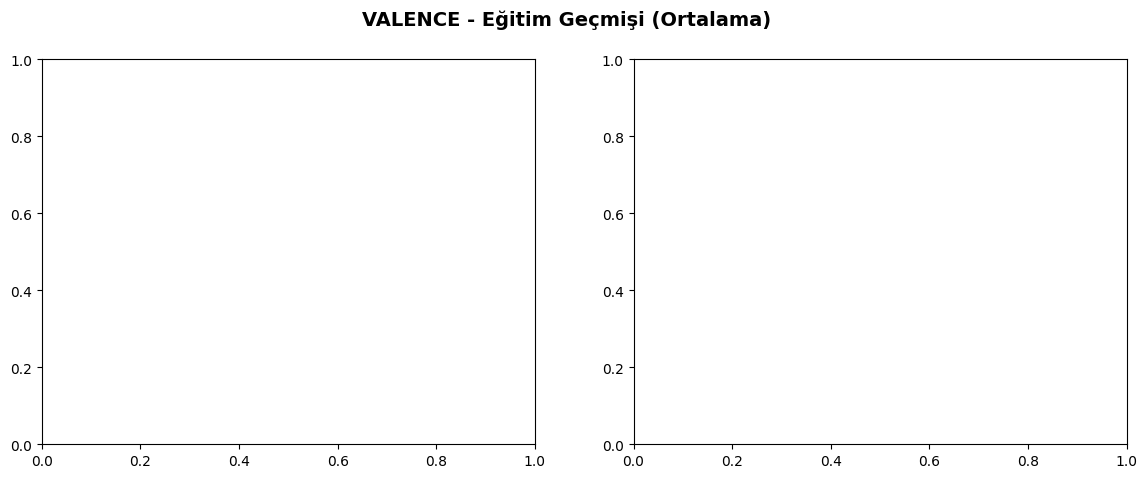

In [ ]:
# Notebook'u çalıştır
if __name__ == "__main__":
    valence_results, arousal_results = main_pipeline()

    print("\n✓ Notebook tamamlandı!")
    print("✓ Model ağırlıkları kaydedildi (best_model_*.h5)")
    print("✓ Sonuç grafikleri oluşturuldu")